## Setup - imports, time, parameters, size function

In [1]:
runno = '7491'

In [2]:
from invisible_cities.database import load_db

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sys import getsizeof

In [4]:
import sys

def get_size(obj, seen=None,):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [5]:
from time import time as time
t0 = time()

In [6]:
# Fit functions

def gauss(x, A, m, s):
    if s < 0:
        return 10000000000000000
    return A*np.exp(-(x-m)**2 / (2*s**2))

def gauss2(x, A, m, v): 
    if v <= 0:
        return 1e10
    return A*np.exp(-(x-m)**2 / (2*v))

def offset_gauss(x, A, m, v, C):
    return C + A*np.exp(-(x-m)**2 / (2*v))

def const(x, a):
    return a + 0*x

def line(x, m, b):
    return m*x + b

from scipy.optimize import curve_fit

def exp_dt(sig):
    """
    expected drift distance  as a function of sigma of the S2 signal (Zrms from kdst 2018 version)
    parameters from the ad-hoc fit
    """
    p = [-10.00667732,  52.1855012,   12.68195726,  58.66322846, -20.11819297]
    dt = p[0] * sig**4 + p[1] * sig**3 + p[2]*sig**2 + p[3]*sig + p[4]
    return dt

## HIGH STATISTICS COMBINED FILE READING

In [7]:
f = open('/Volumes/NEXT_data/IC_Data/krThesis/sliding_window_events/meshed_outputs_20201222/meshed_output_allfiles_'+runno+'.json')
histat_data = json.load(f)
f.close()

In [8]:
histat_data.keys()

dict_keys(['events_energy', 'events_prewindow_sums', 'all_Zgauss', 'all_Wgauss', 'all_Zrms', 'all_Wrms', 'events_X_sipm_subtracted', 'events_Y_sipm_subtracted', 'all_R2', 'events_postwindow_sums', 'all_sres', 'all_ssres'])

In [9]:
len(histat_data['events_energy'])

690182

In [10]:
histat_events_energy_subtracted_pre = np.array(histat_data['events_energy']) - np.array(histat_data['events_prewindow_sums'])
histat_events_energy_subtracted_post = np.array(histat_data['events_energy']) - np.array(histat_data['events_postwindow_sums'])
histat_prepostavg = np.array(histat_data['events_postwindow_sums']) / 2 + np.array(histat_data['events_postwindow_sums']) / 2
histat_events_energy_subtracted_avg = np.array(histat_data['events_energy']) - histat_prepostavg

histat_Zgauss = np.array(histat_data['all_Zgauss'])
histat_Zrms = np.array(histat_data['all_Zrms'])
histatX, histatY = np.array(histat_data['events_X_sipm_subtracted']), np.array(histat_data['events_Y_sipm_subtracted'])
histatR2 = np.array(histat_data['all_R2'])
histatSRES = np.array(histat_data['all_sres'])
histatSSRES = np.array(histat_data['all_ssres'])

In [11]:
import itertools as it
zlims = [100, 200, 300, 400, 510]
rlims = [50, 100, 150, 180]
nomask = np.ones(len(histatR2), dtype='bool')

def get_bin_from_xy(x, y, emap, bounds):
    lowerx, lowery = bounds[0][0], bounds[1][0]
    upperx, uppery = bounds[0][1], bounds[1][1]
    nbinsx = len(emap)
    nbinsy = len(emap[0])
    dbinx = (bounds[0][1] - bounds[0][0]) / nbinsx
    dbiny = (bounds[1][1] - bounds[1][0]) / nbinsy
    ix = min(floor((x - lowerx) / dbinx), nbinsx-1)
    iy = min(floor((y - lowery) / dbiny), nbinsy-1)
    return ix, iy

def correct_energies(emap, bounds, umask = nomask, ltmap = None, show = True, xvals = histatX, yvals = histatY, energies = histat_events_energy_subtracted_pre, vocal = False):
    if vocal:
        print('Correcting energies...')
    ecorrs = []
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    tcorstart = time()
    masked_xvals, masked_yvals = xvals[umask & xymask], yvals[umask & xymask]
    masked_energies = energies[umask & xymask]
    ncorevents = len(masked_xvals)
    factor_default = emap[int(len(emap)/2)][int(len(emap)/2)]
    for e in range(ncorevents):
        if vocal and e % 100000 == 0:
            print(e, '/', len(xvals[umask & xymask]))
            if e > 0:
                print('Est remaining =', round((ncorevents - e)*(time() - tcorstart) / e, 1))
        x, y = masked_xvals[e], masked_yvals[e]
        ix, iy = get_bin_from_xy(x, y, emap, bounds)
        factor = emap[ix][iy]
        if factor == 0 or np.isnan(factor):
            factor = factor_default
        if ltmap is not None:
            ixlt, iylt = get_bin_from_xy(x, y, ltmap, bounds)
            lt = ltmap[ixlt][iylt]
            z = all_Zgauss[umask & xymask][e]
            ltcorr = np.exp(z / lt)
            factor /= ltcorr
        ecorr = masked_energies[e] / factor
        ecorrs.append(ecorr)
    if show:
        plt.hist(ecorrs)
        plt.show()
    return np.array(ecorrs)

def fit_res_vs_zr(energies, emap, bounds, umask = nomask, show = True, xvals = histatX, yvals = histatY, zvals = histat_Zgauss):
    res_vs_zr = {}
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    masked_xvals, masked_yvals, masked_zvals = xvals[umask & xymask], yvals[umask & xymask], zvals[umask & xymask]

    for zlim, rlim in it.product(zlims, rlims):
    
        fidmask = ((masked_xvals**2 + masked_yvals**2) < rlim**2) & (masked_zvals < zlim)
        h = plt.hist(energies[fidmask], range=(0.85, 1.15), bins = 30)

        xdata = (h[1][:-1] + h[1][1:]) / 2
        ydata = h[0]

        (A0, m0, s0) = (np.max(ydata), 1, np.std(energies[fidmask]))
        
        popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
        fitgauss = gauss(xdata, *popt)

        FWHM = 2.355 * popt[2]
        mean = popt[1]
        resolution = 100 * FWHM / mean

        res_vs_zr[zlim*1000+rlim] = resolution

        if zlim == zlims[0] and rlim == rlims[0] and show:
            print('Fit a Gaussian with guess (A0, m0, s0) =', (A0, m0, s0))
            plt.plot(xdata, fitgauss)
            plt.title('Z < '+str(zlim)+'; R < '+str(rlim)+'. Resolution = '+str(round(resolution, 1))+'%')
            plt.show()
        else:
            plt.close()
    
    return res_vs_zr

def plot_res_vs_zr(res_vs_zr):
    for rlim in rlims:
        res_vs_z = [ res_vs_zr[1000*zlim + rlim] for zlim in zlims ]
        plt.plot(zlims, res_vs_z, 'o', label = 'rlim = '+str(rlim)+' mm')
    plt.legend()
    plt.xlabel('Z upper limit (mm)')
    plt.ylabel('Resolution (%)')
    plt.show()
    print('Innermost resolution = ', round(res_vs_zr[1000*zlims[0] + rlims[0]], 2), '%')
    print('Outermost resolution = ', round(res_vs_zr[1000*zlims[-1] + rlims[-1]], 2), '%')
    
import h5py

def load_maps_from_file(filename, show = True):
    f = h5py.File(filename, 'r')
    e0map = np.array(f['e0']['block0_values'])
    ltmap = np.array(f['lt']['block0_values'])
    # f['mapinfo']['index'][i] tells you what is stored is stored in f['mapinfo']['values'][i]
    bounds = ((f['mapinfo']['values'][0], f['mapinfo']['values'][1]), (f['mapinfo']['values'][2], f['mapinfo']['values'][3]))
    f.close()

    if show:
        plt.imshow(e0map, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('E0')
        plt.show()

        plt.imshow(ltmap, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('LT')
        plt.clim(5000, 10000)
        plt.show()
    
    return e0map, ltmap, bounds

## Determine the range of the peak

### R2, SRES, SSRES distributions

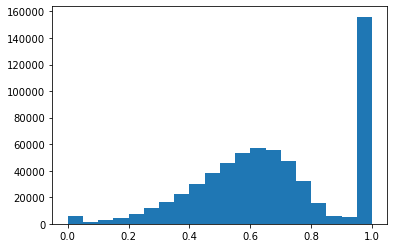

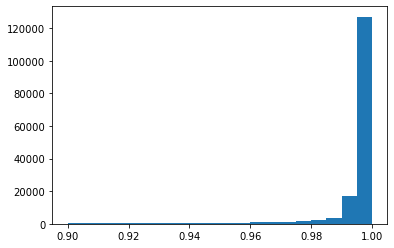

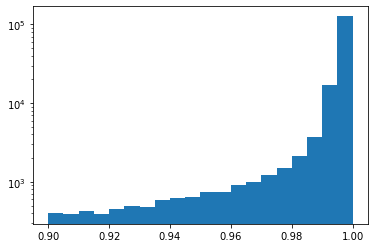

In [12]:
plt.hist(histatR2, range=(0, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.yscale('log')
plt.show()

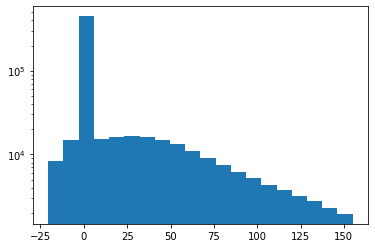

In [13]:
plt.hist(histatSRES, range=(np.percentile( histatSRES, 5), np.percentile( histatSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

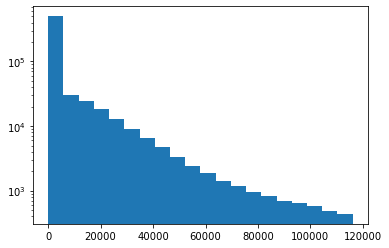

In [14]:
plt.hist(histatSSRES, range=(np.percentile( histatSSRES, 5), np.percentile( histatSSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

In [15]:
# Constant cuts
noise_bound = 0
zmax = 510
hienergybound = 2 # Events with double the median energy are excluded as possible Kr events

In [16]:
# Choose your analysis parameters:
# histat_events_energy_subtracted = histat_events_energy_subtracted_pre
# r2cut = 0.98
# histatZ = histat_Zgauss

## Check XYZ distributions

Peak range = 5552.1 , 11651.3
Selected percentage = 10.8 %


/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in true_divide


Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 18.9
200000 / 583410
Est remaining = 14.5
300000 / 583410
Est remaining = 10.7
400000 / 583410
Est remaining = 7.0
500000 / 583410
Est remaining = 3.6


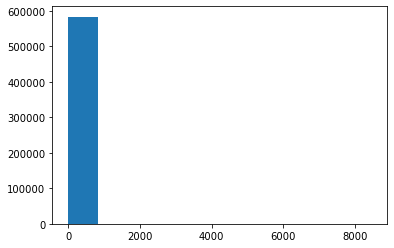

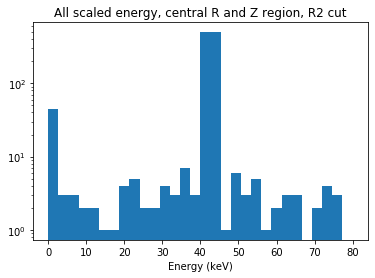

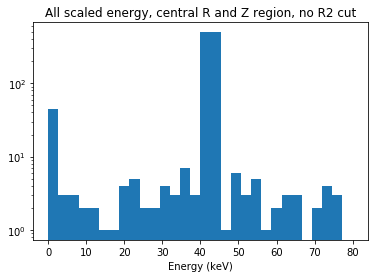

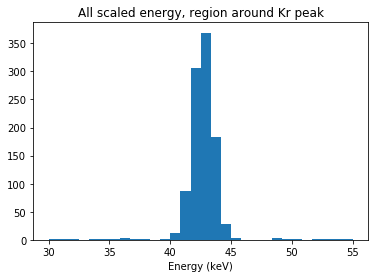

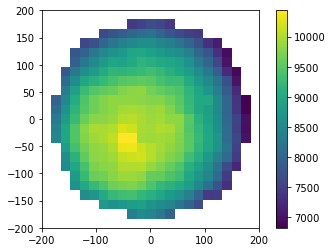

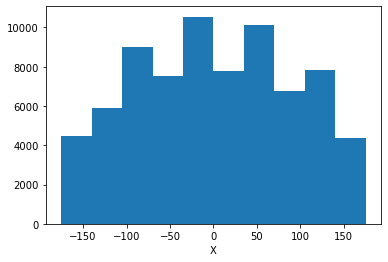

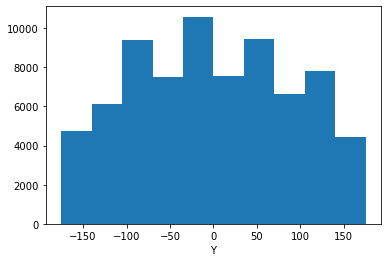

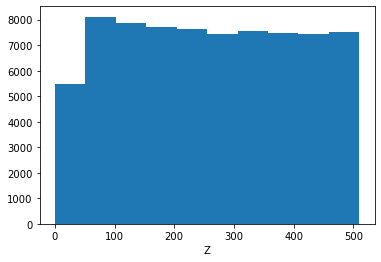

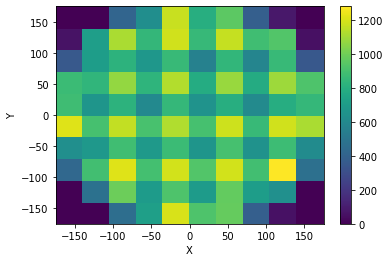

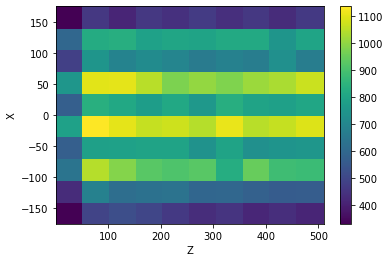

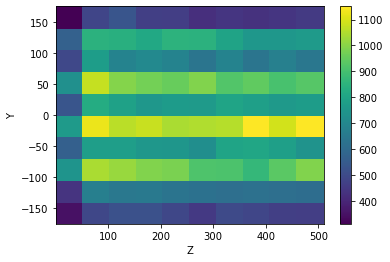

In [17]:
r2cut = 0.9
histatZ = histat_Zgauss
r2mask = histatR2 > r2cut
zmask = (histatZ > 0) & (histatZ < zmax)
rmask = histatX**2 + histatY**2 < 180**2
r2ZRnoisemask = r2mask & zmask & rmask # & (histat_events_energy_subtracted_pre > noise_bound)
hienergymask = histat_events_energy_subtracted_pre < hienergybound * np.percentile(histat_events_energy_subtracted_pre[r2ZRnoisemask], 50)
r2ZRhinoisemask = r2ZRnoisemask & hienergymask

med = np.median(histat_events_energy_subtracted_pre[r2ZRhinoisemask])
frac = 0.6827
lowcut = 0.5 - frac / 2
hicut = 0.5 + frac / 2
lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * lowcut))
rgt = med + 3 * (np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * hicut) - med)
print('Peak range =', round(lft,1),',', round(rgt,1))
histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted_pre > lft) & (histat_events_energy_subtracted_pre < rgt)
print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '%')

# Create own correction map
nbins = 23
clim = 200
dbin = 2 * clim / nbins
coord_range = np.linspace(-clim, clim, nbins + 1)
coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
events_sum = np.zeros((len(coord_bins),len(coord_bins)))
for ix in range(len(coord_bins)):
    for iy in range(len(coord_bins)):
        xbin = coord_bins[ix]
        ybin = coord_bins[iy]
        xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
        ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
        xymask = xmask & ymask
        events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
        energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted_pre[xymask & histat_selfmask])

energy_xy = energy_sum / events_sum
energy_xy_bounds = ((-200, 200), (-200, 200))

# Apply the correction
histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted_pre, xvals = histatX, yvals = histatY, vocal = True)
histat_all_scaled_energy *= 41.5



# Final cut spectra
histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, central R and Z region, R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, central R and Z region, no R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
plt.title('All scaled energy, region around Kr peak')
plt.xlabel('Energy (keV)')
plt.show()


plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
plt.colorbar()
plt.show()


plt.hist(histatX[histat_selfmask])
plt.xlabel('X')
plt.show()

plt.hist(histatY[histat_selfmask])
plt.xlabel('Y')
plt.show()

plt.hist(histatZ[histat_selfmask])
plt.xlabel('Z')
plt.show()

h = plt.hist2d(histatX[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatX[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('X')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

In [18]:
def check_resolution(histatZ, histat_events_energy_subtracted, r2cut):

    # Create masks
    r2mask = histatR2 > r2cut
    zmask = (histatZ > 0) & (histatZ < zmax)
    rmask = histatX**2 + histatY**2 < 180**2
    r2ZRnoisemask = r2mask & (histat_events_energy_subtracted > noise_bound) & zmask & rmask
    hienergymask = histat_events_energy_subtracted < hienergybound * np.percentile(histat_events_energy_subtracted[r2ZRnoisemask], 50)
    r2ZRhinoisemask = r2ZRnoisemask & hienergymask

    # Set peak range
    med = np.median(histat_events_energy_subtracted[r2ZRhinoisemask])
    frac = 0.6827
    lowcut = 0.5 - frac / 2
    hicut = 0.5 + frac / 2
    lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * lowcut))
    rgt = med + 3 * (np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * hicut) - med)
    print('Peak range =', round(lft,1),',', round(rgt,1))
    histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted > lft) & (histat_events_energy_subtracted < rgt)
    print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '\%')
    
    # Plot spectra after applying various cuts
    plt.hist(histat_events_energy_subtracted, bins = 25)
    plt.yscale('log')
    plt.title('Full spectrum')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted, range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(lft, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[histat_selfmask], bins = 25)
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut; linear scale')
    plt.xlabel('Energy (pes)')
    plt.show()

    # Noise spectrum
    plt.hist(histat_events_energy_subtracted, range=(0, 500), bins = 25)
    plt.title('Noise spectrum')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_events_energy_subtracted[~r2mask], range=(0, 500), bins = 25)
    plt.title('Noise spectrum, bad R2')
    plt.yscale('log')
    plt.show()

    # Create own correction map
    nbins = 23
    clim = 200
    dbin = 2 * clim / nbins
    coord_range = np.linspace(-clim, clim, nbins + 1)
    coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

    energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
    events_sum = np.zeros((len(coord_bins),len(coord_bins)))
    for ix in range(len(coord_bins)):
        for iy in range(len(coord_bins)):
            xbin = coord_bins[ix]
            ybin = coord_bins[iy]
            xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
            ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
            xymask = xmask & ymask
            events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
            energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted[xymask & histat_selfmask])

    energy_xy = energy_sum / events_sum
    energy_xy_bounds = ((-200, 200), (-200, 200))

    plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    map_out = './maps_from_maxsipm/map_'+runno+'.npy'

    with open(map_out, 'wb') as f:
        np.save(f, energy_xy)

    with open(map_out, 'rb') as f:
        test_readin_xy = np.load(f)

    plt.imshow(test_readin_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    # Apply the correction
    histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
    histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)
    histat_all_scaled_energy *= 41.5

    plt.hist(histat_all_scaled_energy, range = (0, 80), bins = 20)
    plt.title('All scaled energy')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    # Final cut spectra
    histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    histat_center_mask = (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, no R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
    plt.title('All scaled energy, region around Kr peak, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.show()

    # r7472_scaled_energy = correct_energies(e0_7472, bounds_7472, umask = selfmask, ltmap = lt_7472)
    # r7472_res_vs_zr = fit_res_vs_zr(r7472_scaled_energy, e0_7472, bounds_7472, umask = selfmask)
    histat_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_selfmask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)

    histat_self_res_vs_zr = fit_res_vs_zr(histat_scaled_energy, energy_xy, energy_xy_bounds, umask = histat_selfmask, xvals = histatX, yvals = histatY, zvals = histatZ)
    plot_res_vs_zr(histat_self_res_vs_zr)
    print('All resolutions:', histat_self_res_vs_zr)
    
    return histat_self_res_vs_zr


================ CHECKING R2 CUT = 0.4 ================
Peak range = 4732.0 , 11740.7
Selected percentage = 10.9 \%


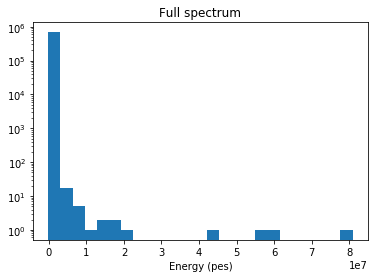

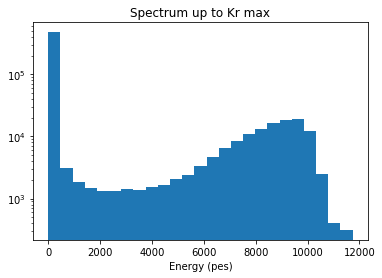

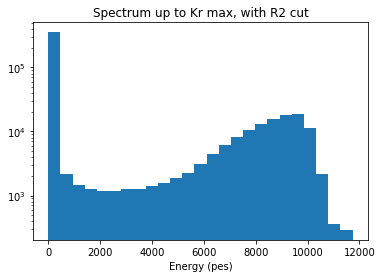

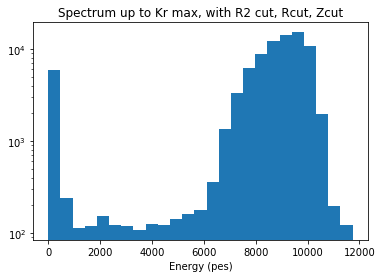

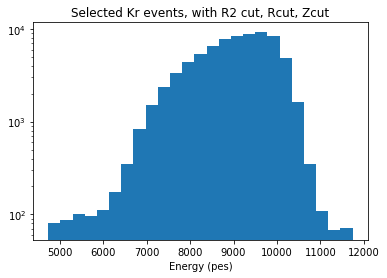

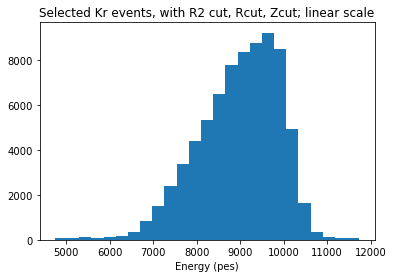

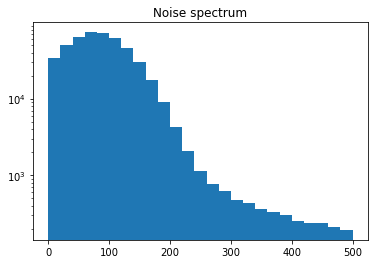

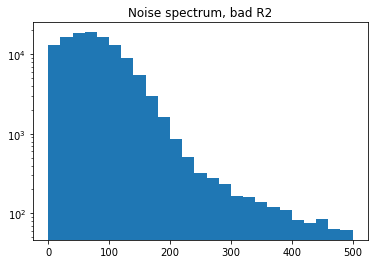

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


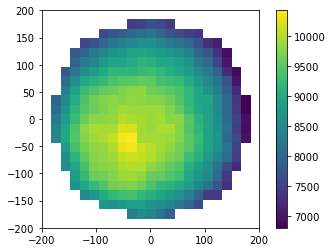

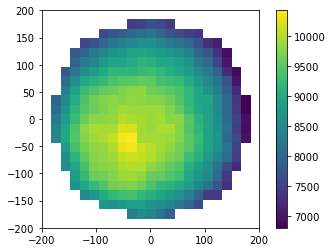

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 18.2
200000 / 583410
Est remaining = 14.3
300000 / 583410
Est remaining = 10.6
400000 / 583410
Est remaining = 6.9
500000 / 583410
Est remaining = 3.1


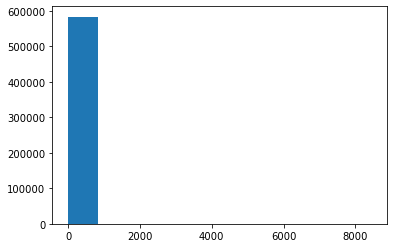

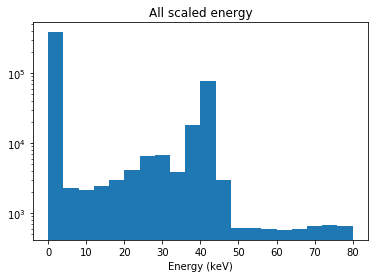

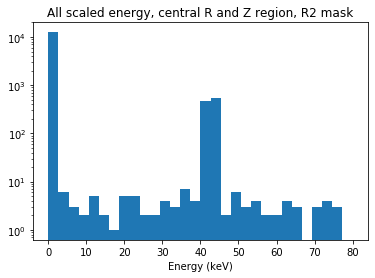

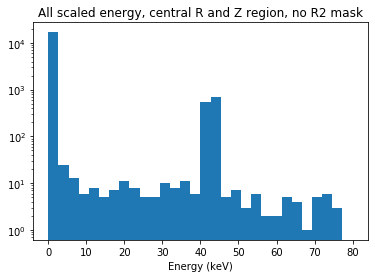

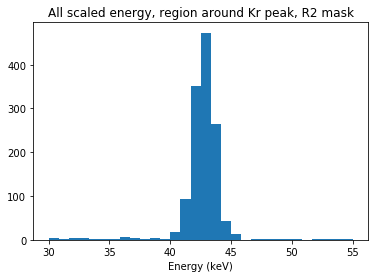

Correcting energies...
0 / 75013


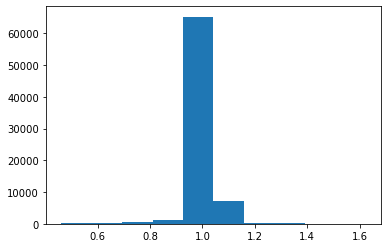

Fit a Gaussian with guess (A0, m0, s0) = (190.0, 1, 0.056715679889558515)


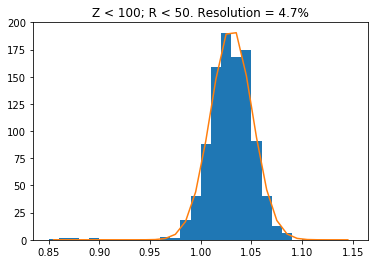

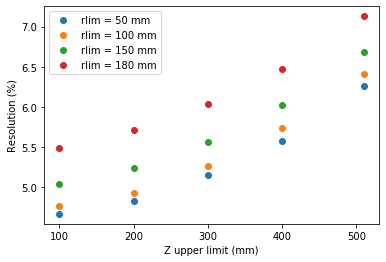

Innermost resolution =  4.67 %
Outermost resolution =  7.13 %
All resolutions: {100050: 4.668612005074428, 100100: 4.77089897539285, 100150: 5.040708690743531, 100180: 5.485325395636816, 200050: 4.831228878418223, 200100: 4.93449279942975, 200150: 5.242119631218778, 200180: 5.714679732226393, 300050: 5.152178809284683, 300100: 5.269518048670469, 300150: 5.5631965480346075, 300180: 6.033936236046022, 400050: 5.579491256302589, 400100: 5.7331753997414525, 400150: 6.025728426983361, 400180: 6.4763193175147835, 510050: 6.267048938274512, 510100: 6.406048484184909, 510150: 6.678874408322543, 510180: 7.129648032131158}

================ CHECKING R2 CUT = 0.5 ================
Peak range = 4886.2 , 11730.8
Selected percentage = 10.9 \%


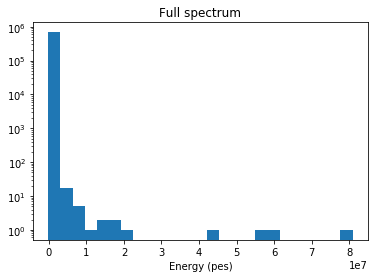

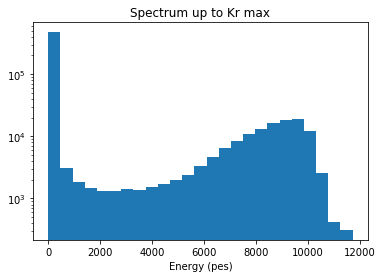

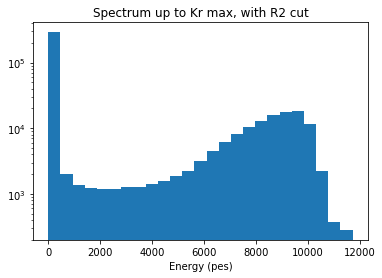

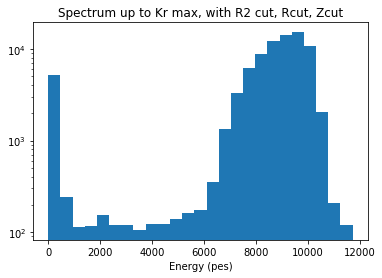

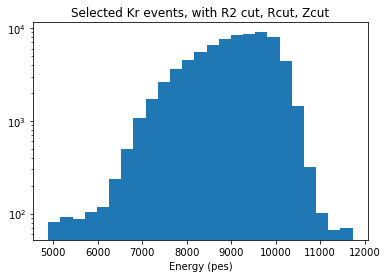

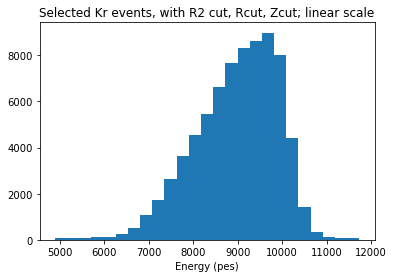

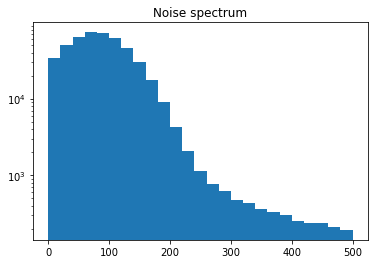

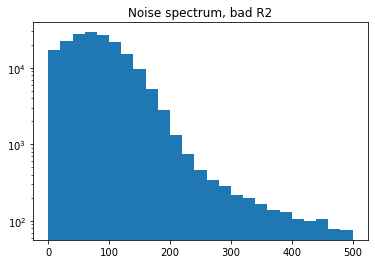

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


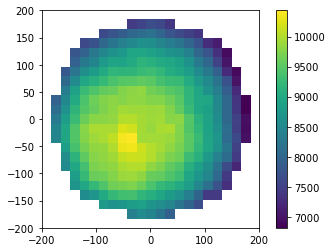

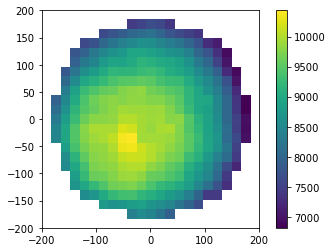

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 18.2
200000 / 583410
Est remaining = 16.2
300000 / 583410
Est remaining = 12.3
400000 / 583410
Est remaining = 7.7
500000 / 583410
Est remaining = 3.4


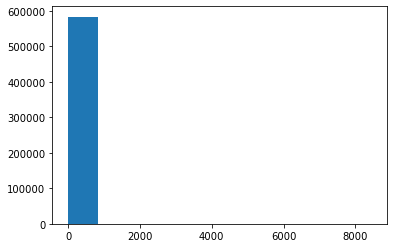

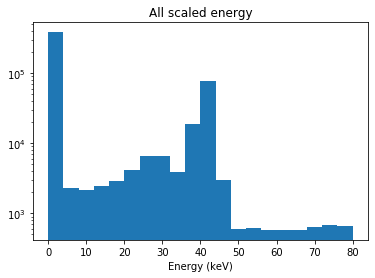

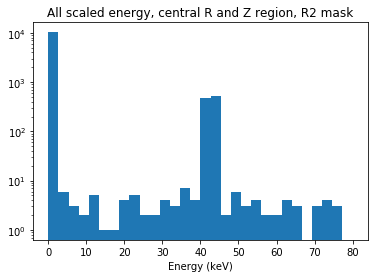

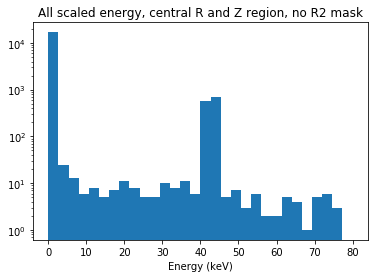

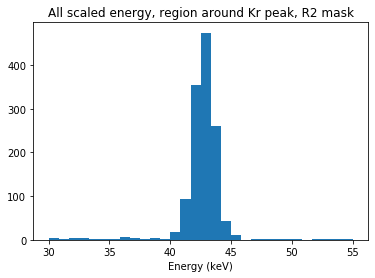

Correcting energies...
0 / 74965


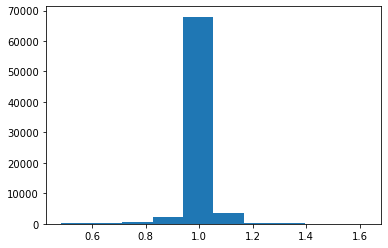

Fit a Gaussian with guess (A0, m0, s0) = (191.0, 1, 0.05159135015758279)


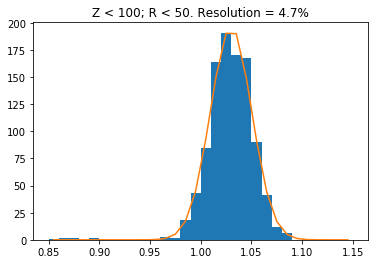

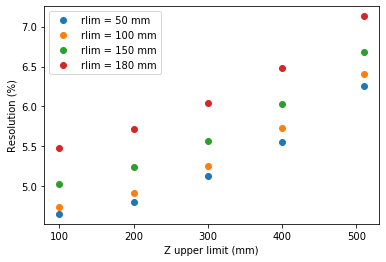

Innermost resolution =  4.65 %
Outermost resolution =  7.13 %
All resolutions: {100050: 4.654253613121368, 100100: 4.737824822406483, 100150: 5.023919014023738, 100180: 5.480618932065796, 200050: 4.807825182486187, 200100: 4.917460440697595, 200150: 5.236939716015963, 200180: 5.719348007087433, 300050: 5.1261058266701065, 300100: 5.2587676439379045, 300150: 5.5625341647728135, 300180: 6.0383341704587234, 400050: 5.557224441694939, 400100: 5.731238705434526, 400150: 6.028166251032241, 400180: 6.479398428142573, 510050: 6.261856026080682, 510100: 6.410669767626728, 510150: 6.68115852964485, 510180: 7.13045474325674}

================ CHECKING R2 CUT = 0.6 ================
Peak range = 5054.0 , 11714.1
Selected percentage = 10.9 \%


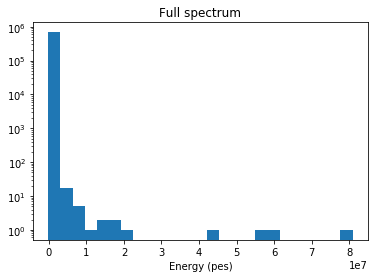

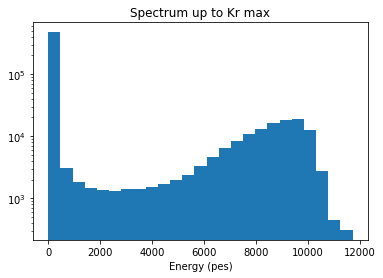

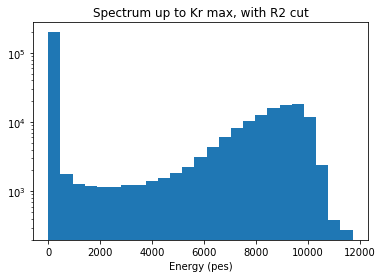

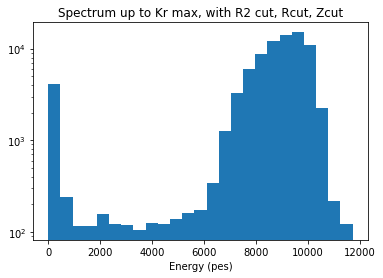

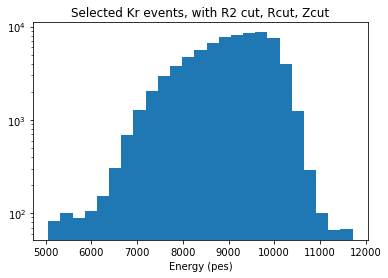

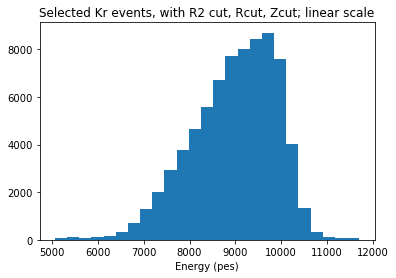

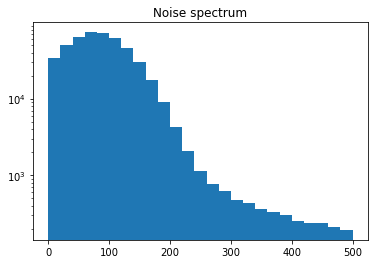

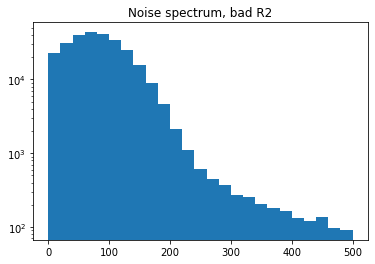

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


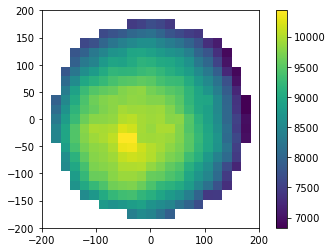

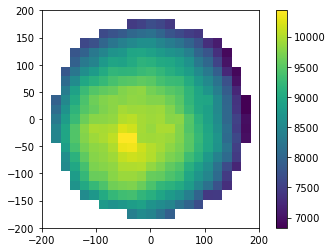

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 27.4
200000 / 583410
Est remaining = 25.0
300000 / 583410
Est remaining = 17.7
400000 / 583410
Est remaining = 11.5
500000 / 583410
Est remaining = 5.0


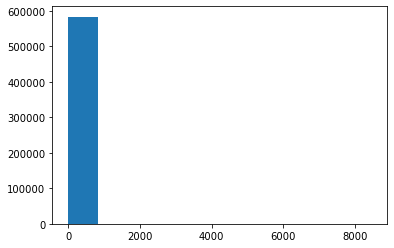

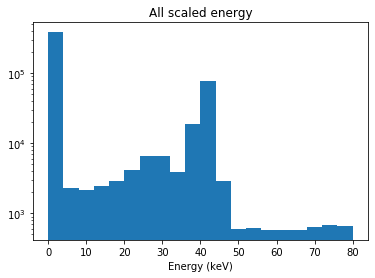

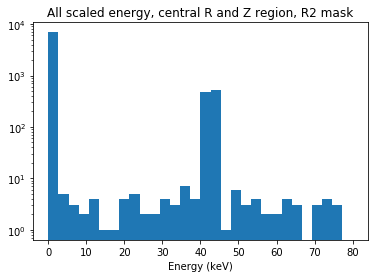

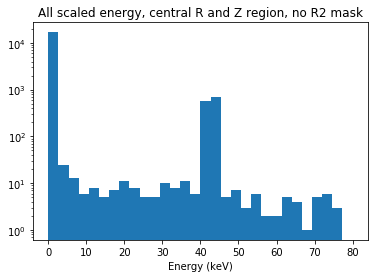

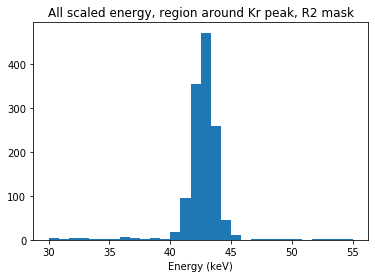

Correcting energies...
0 / 74906


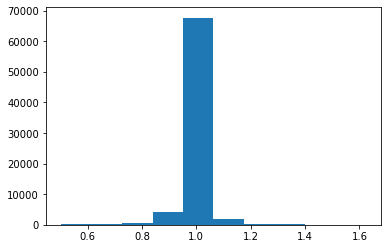

Fit a Gaussian with guess (A0, m0, s0) = (189.0, 1, 0.05157826945288462)


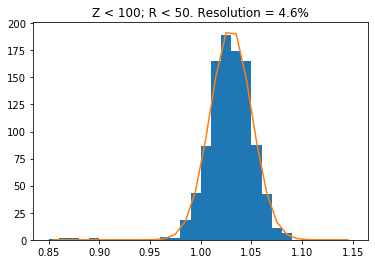

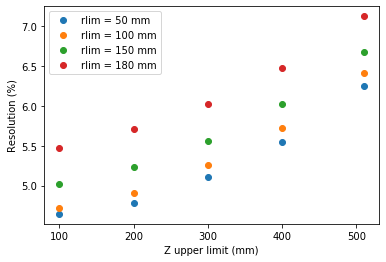

Innermost resolution =  4.65 %
Outermost resolution =  7.12 %
All resolutions: {100050: 4.645447295206929, 100100: 4.723078803254479, 100150: 5.01443806601385, 100180: 5.469500009045771, 200050: 4.787958725881665, 200100: 4.90988914570117, 200150: 5.230410699853224, 200180: 5.705569608122174, 300050: 5.114075451601286, 300100: 5.255516392784365, 300150: 5.556408107763016, 300180: 6.025416761890603, 400050: 5.54170205983393, 400100: 5.728555060929055, 400150: 6.021005238933333, 400180: 6.469576797229248, 510050: 6.248536755153964, 510100: 6.409389586876469, 510150: 6.675857300165542, 510180: 7.124870972867389}

================ CHECKING R2 CUT = 0.7 ================
Peak range = 5286.4 , 11689.8
Selected percentage = 10.8 \%


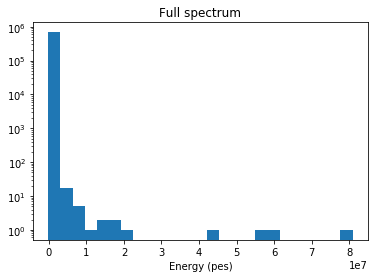

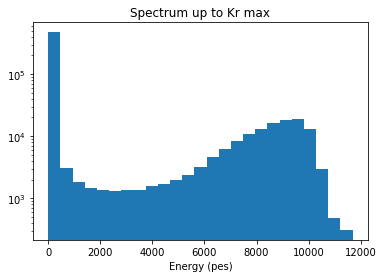

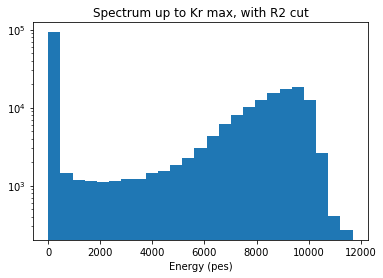

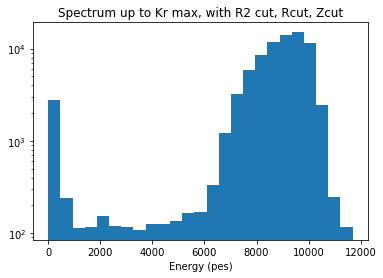

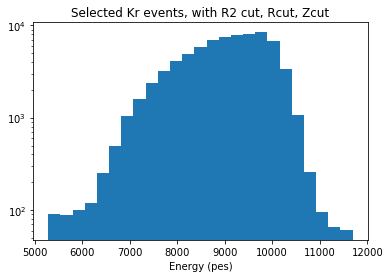

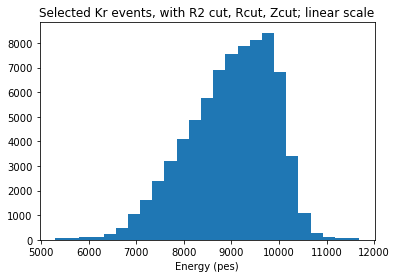

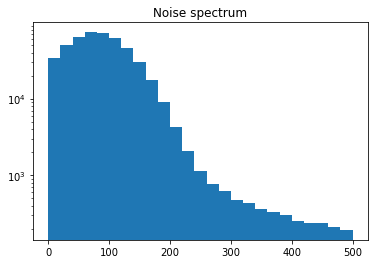

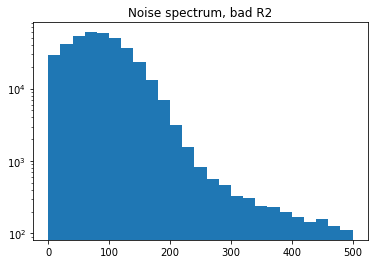

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


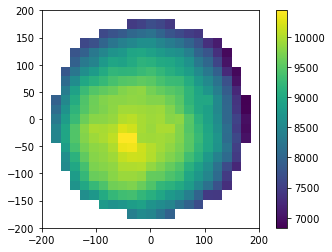

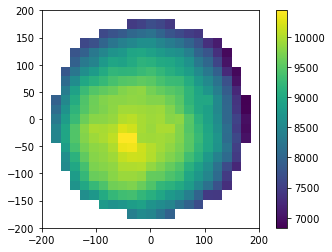

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 23.9
200000 / 583410
Est remaining = 19.7
300000 / 583410
Est remaining = 14.5
400000 / 583410
Est remaining = 9.6
500000 / 583410
Est remaining = 4.2


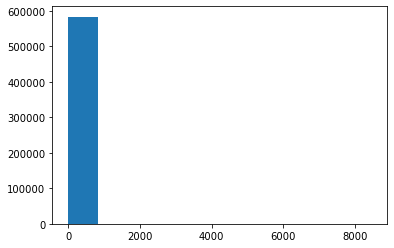

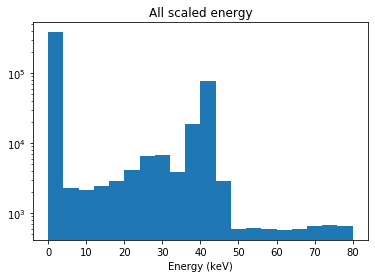

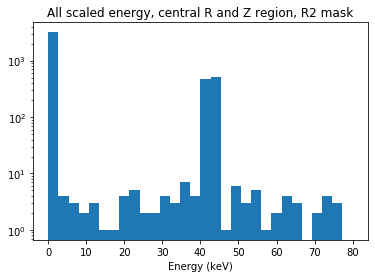

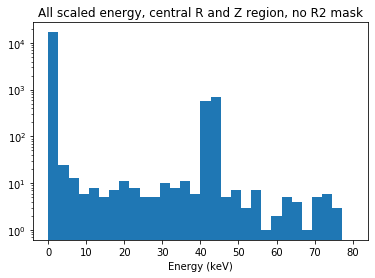

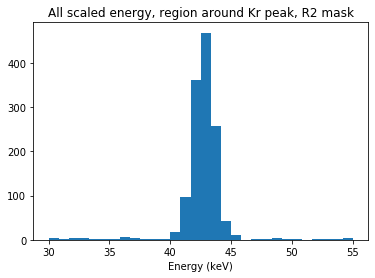

Correcting energies...
0 / 74786


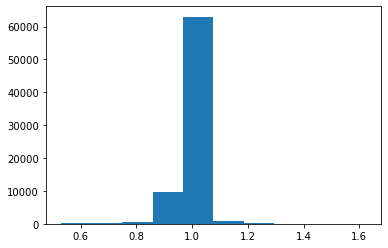

Fit a Gaussian with guess (A0, m0, s0) = (187.0, 1, 0.04650013251280695)


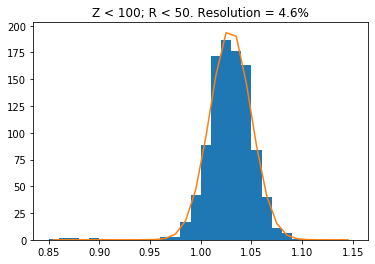

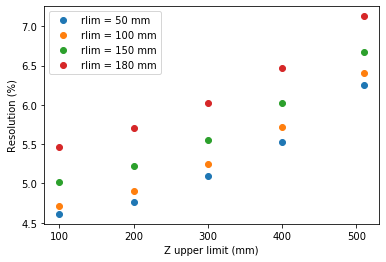

Innermost resolution =  4.61 %
Outermost resolution =  7.13 %
All resolutions: {100050: 4.611430517049236, 100100: 4.707510975764729, 100150: 5.012135162954397, 100180: 5.467860383075252, 200050: 4.768563101430796, 200100: 4.904507789142094, 200150: 5.226456168074368, 200180: 5.70211017267516, 300050: 5.08880800917875, 300100: 5.246758385346683, 300150: 5.550257227924878, 300180: 6.024954022162536, 400050: 5.52891190460745, 400100: 5.719826605819465, 400150: 6.019359752971149, 400180: 6.470325600814066, 510050: 6.255227244261054, 510100: 6.407710078245824, 510150: 6.676799015820816, 510180: 7.12694766391133}

================ CHECKING R2 CUT = 0.8 ================
Peak range = 5484.7 , 11664.0
Selected percentage = 10.8 \%


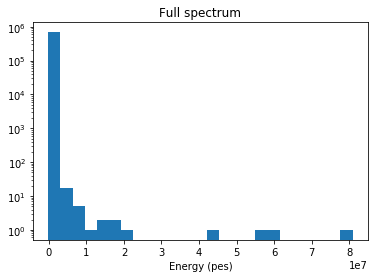

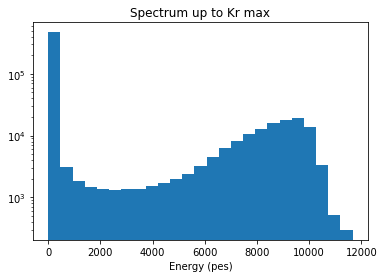

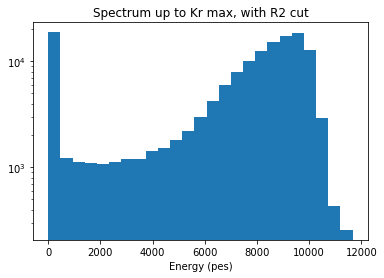

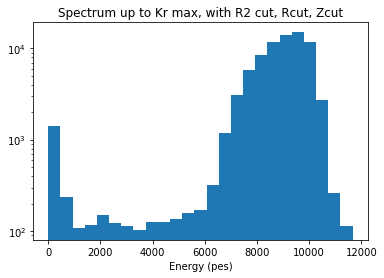

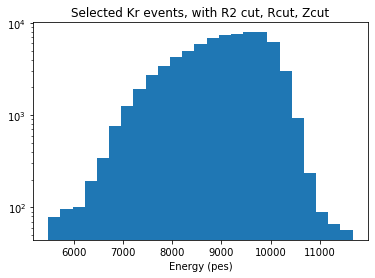

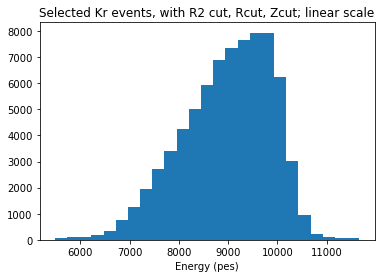

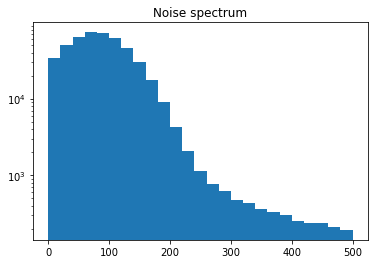

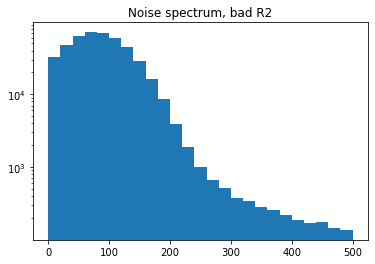

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


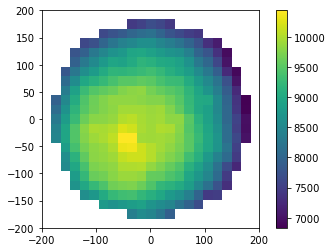

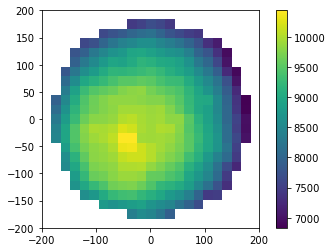

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 20.8
200000 / 583410
Est remaining = 16.2
300000 / 583410
Est remaining = 12.1
400000 / 583410
Est remaining = 7.9
500000 / 583410
Est remaining = 3.8


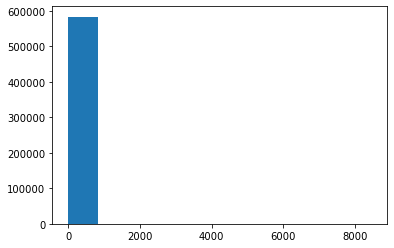

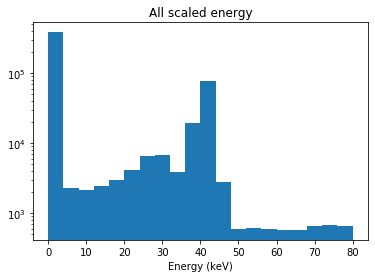

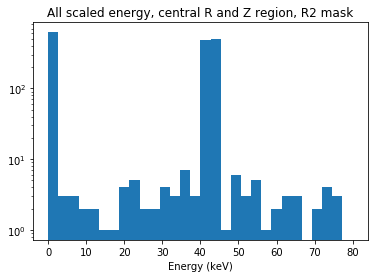

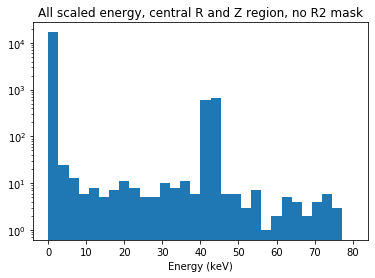

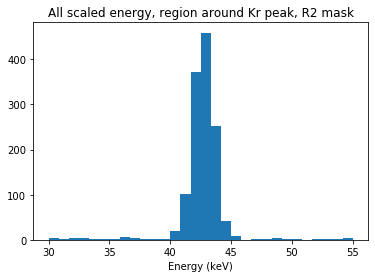

Correcting energies...
0 / 74489


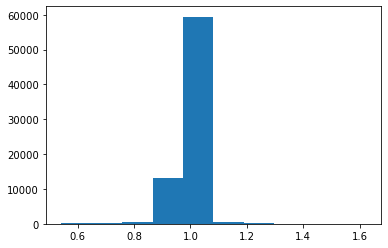

Fit a Gaussian with guess (A0, m0, s0) = (184.0, 1, 0.04117600032640601)


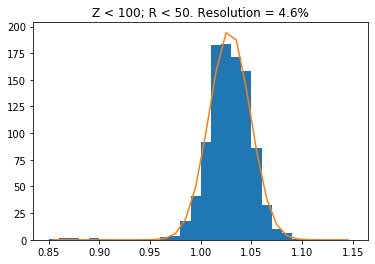

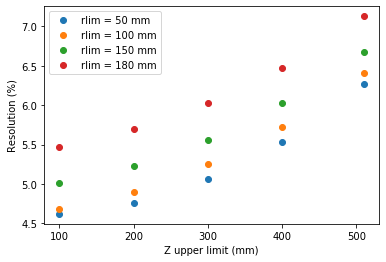

Innermost resolution =  4.62 %
Outermost resolution =  7.13 %
All resolutions: {100050: 4.6213463412187705, 100100: 4.680912484862209, 100150: 5.010853783418025, 100180: 5.463511735592945, 200050: 4.765103399629903, 200100: 4.904322163131079, 200150: 5.230985048382635, 200180: 5.703731350175829, 300050: 5.0696481982788, 300100: 5.249341564252067, 300150: 5.55488274266989, 300180: 6.02323470610842, 400050: 5.530713181341046, 400100: 5.726178749430237, 400150: 6.021203129748867, 400180: 6.469286368643588, 510050: 6.264258785104391, 510100: 6.412483376922611, 510150: 6.67754435941419, 510180: 7.126339223191389}

================ CHECKING R2 CUT = 0.9 ================
Peak range = 5569.0 , 11647.6
Selected percentage = 10.8 \%


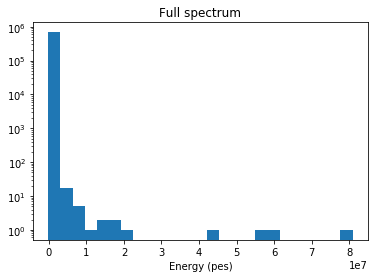

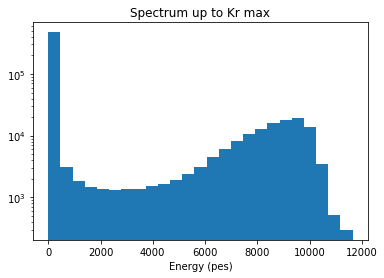

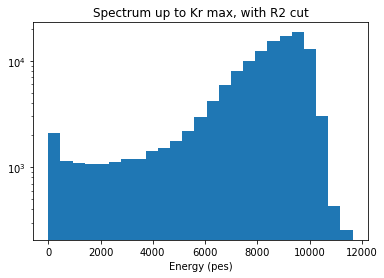

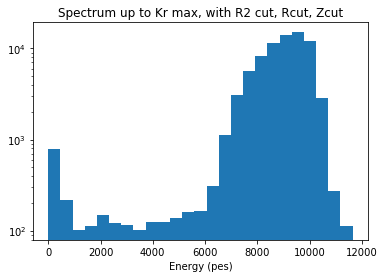

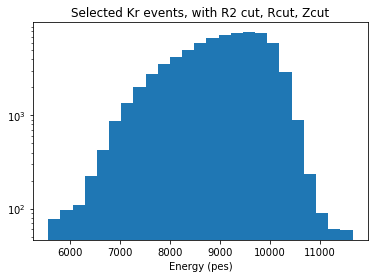

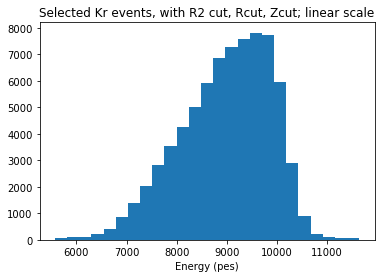

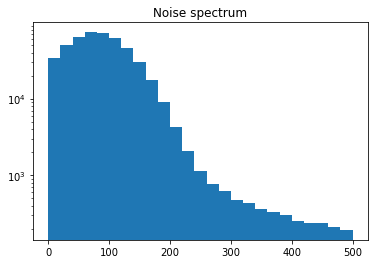

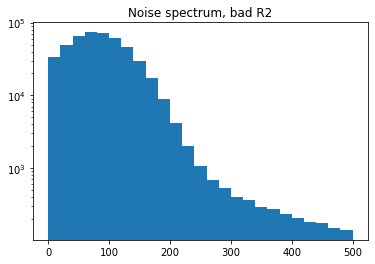

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


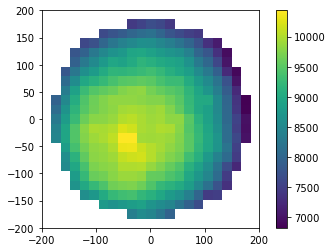

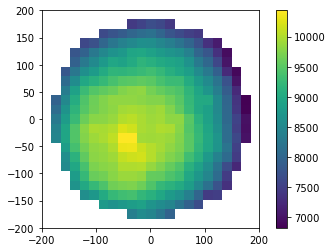

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 20.5
200000 / 583410
Est remaining = 16.9
300000 / 583410
Est remaining = 12.1
400000 / 583410
Est remaining = 8.6
500000 / 583410
Est remaining = 3.9


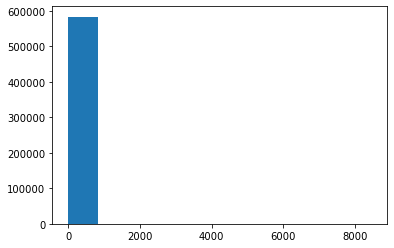

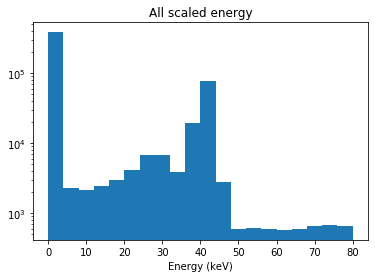

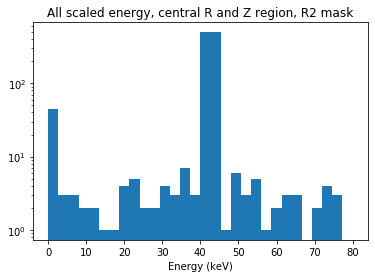

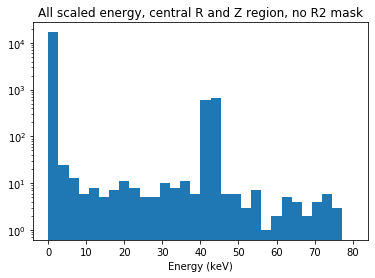

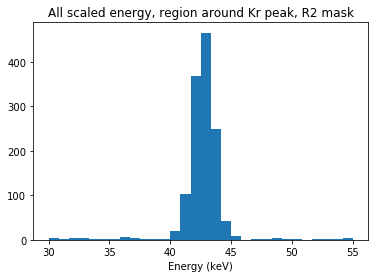

Correcting energies...
0 / 74233


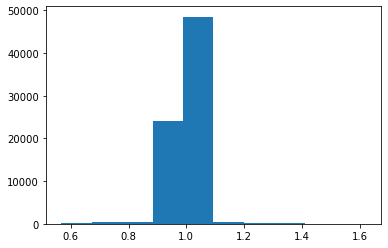

Fit a Gaussian with guess (A0, m0, s0) = (188.0, 1, 0.03847215378701846)


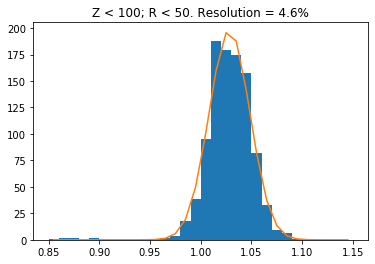

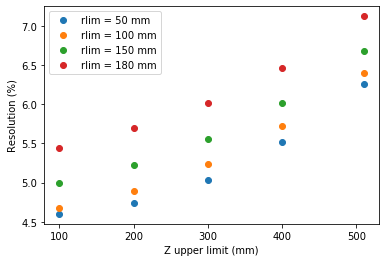

Innermost resolution =  4.6 %
Outermost resolution =  7.12 %
All resolutions: {100050: 4.600789427817213, 100100: 4.675034417518473, 100150: 4.997323995012023, 100180: 5.443770850065623, 200050: 4.739444701136124, 200100: 4.892409475804822, 200150: 5.223293312273904, 200180: 5.695221084528531, 300050: 5.039982931142444, 300100: 5.2389268746926065, 300150: 5.551244010243095, 300180: 6.021263400958608, 400050: 5.518724825976606, 400100: 5.721649378452443, 400150: 6.020476248388029, 400180: 6.46930263362804, 510050: 6.253843012432418, 510100: 6.405257158671606, 510150: 6.676223142545279, 510180: 7.12423141696898}

================ CHECKING R2 CUT = 0.92 ================
Peak range = 5579.2 , 11645.5
Selected percentage = 10.7 \%


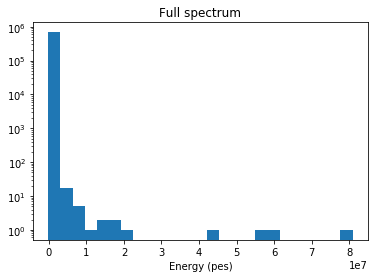

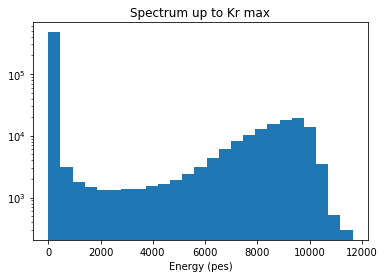

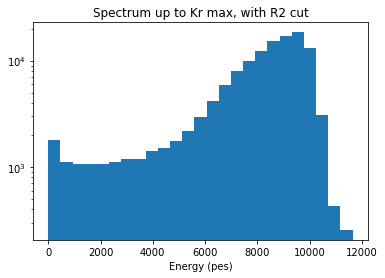

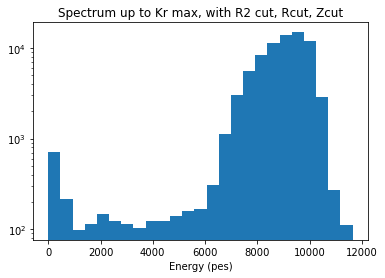

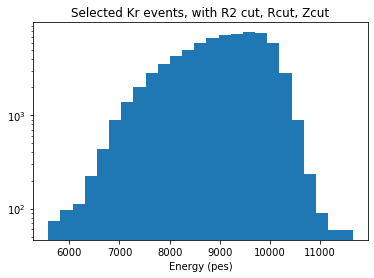

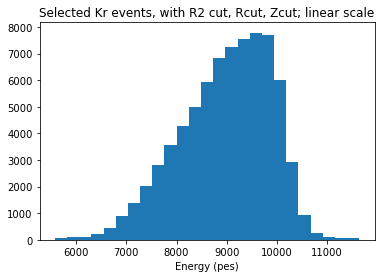

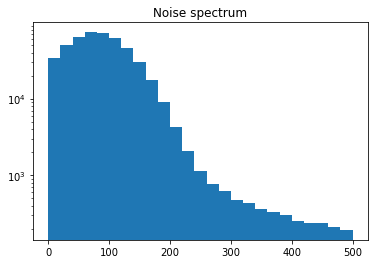

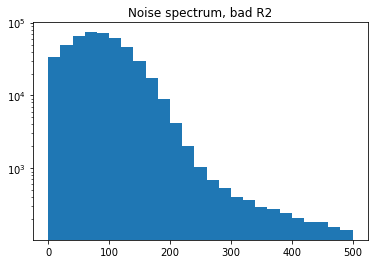

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


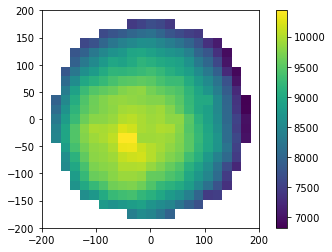

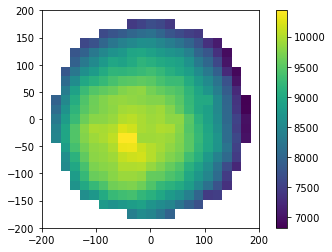

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 27.3
200000 / 583410
Est remaining = 19.2
300000 / 583410
Est remaining = 13.6
400000 / 583410
Est remaining = 8.6
500000 / 583410
Est remaining = 3.9


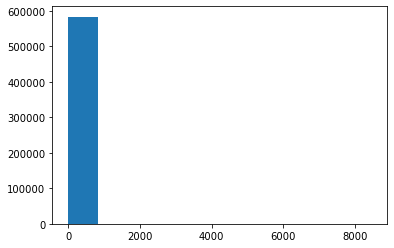

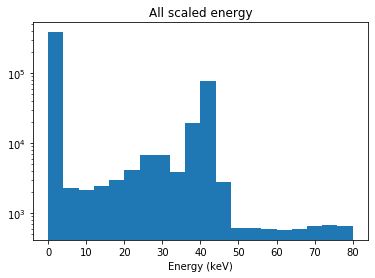

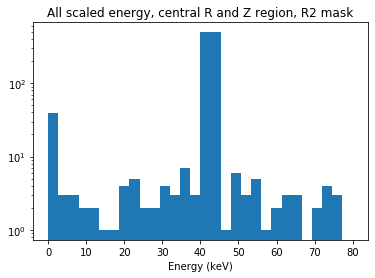

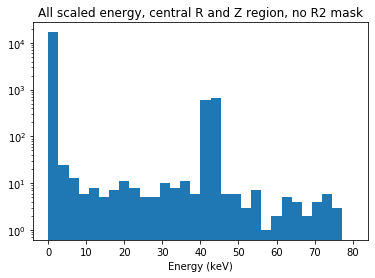

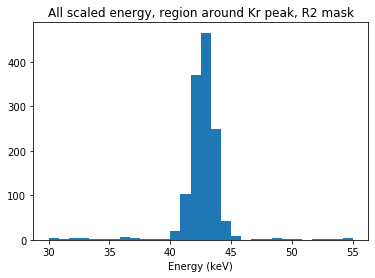

Correcting energies...
0 / 74185


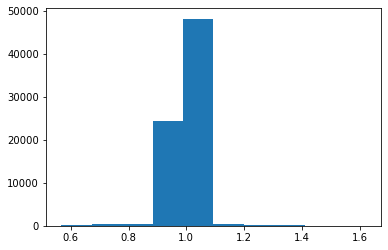

Fit a Gaussian with guess (A0, m0, s0) = (189.0, 1, 0.03850385175184727)


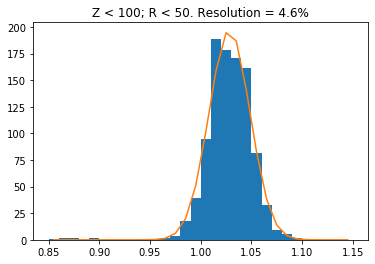

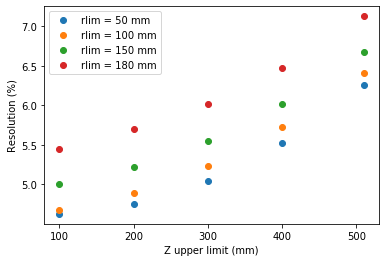

Innermost resolution =  4.63 %
Outermost resolution =  7.13 %
All resolutions: {100050: 4.626587721096047, 100100: 4.677263418826778, 100150: 5.0069773336963435, 100180: 5.449563350474207, 200050: 4.7517326357889464, 200100: 4.886497409598167, 200150: 5.225880018581718, 200180: 5.696146068145008, 300050: 5.048408835111248, 300100: 5.235584968368493, 300150: 5.553442051407825, 300180: 6.022007371575455, 400050: 5.527490037340009, 400100: 5.722056084909639, 400150: 6.021668443658621, 400180: 6.47041915458283, 510050: 6.258162172873546, 510100: 6.406415423724156, 510150: 6.677507629923258, 510180: 7.12522236091777}

================ CHECKING R2 CUT = 0.94 ================
Peak range = 5593.5 , 11642.8
Selected percentage = 10.7 \%


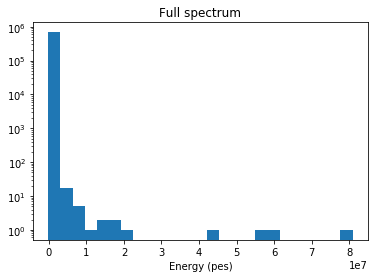

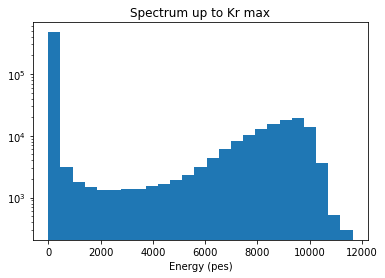

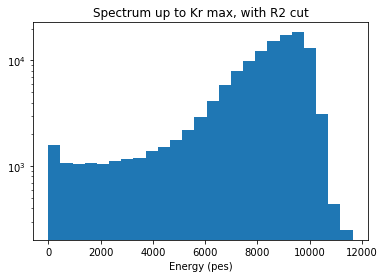

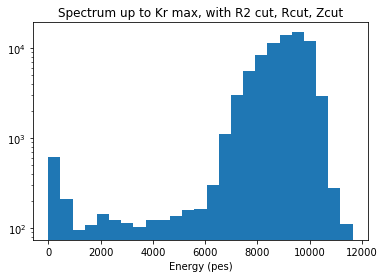

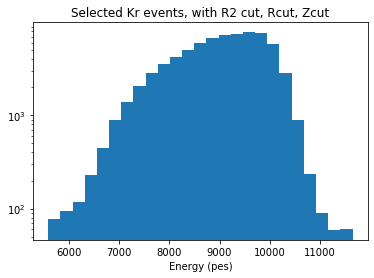

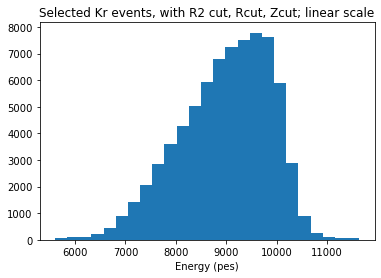

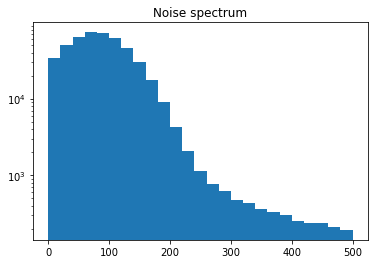

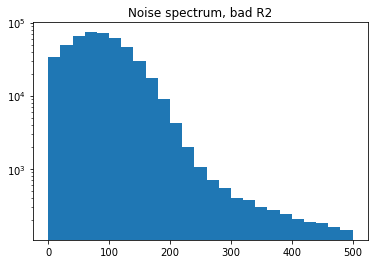

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


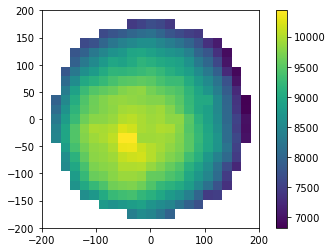

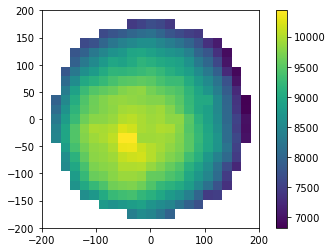

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 13.6
200000 / 583410
Est remaining = 10.5
300000 / 583410
Est remaining = 7.5
400000 / 583410
Est remaining = 4.8
500000 / 583410
Est remaining = 2.1


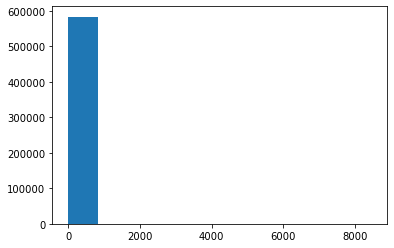

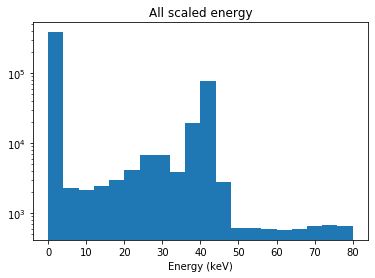

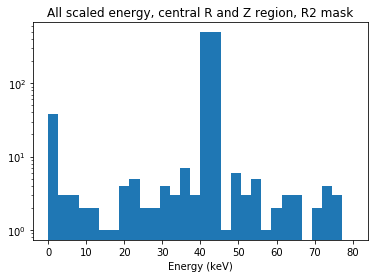

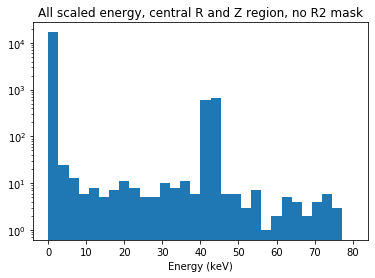

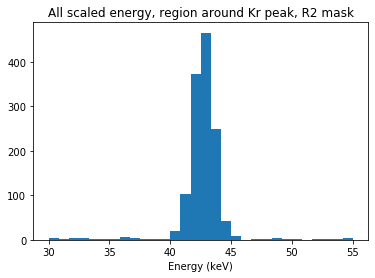

Correcting energies...
0 / 74124


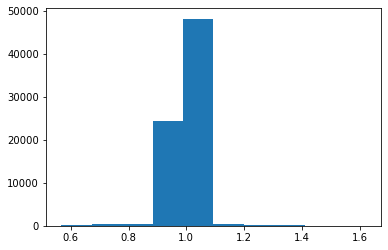

Fit a Gaussian with guess (A0, m0, s0) = (188.0, 1, 0.03851307573991239)


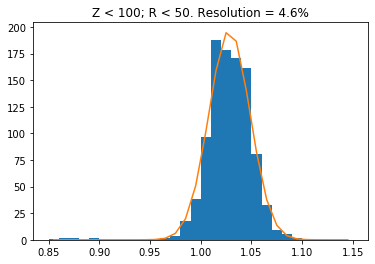

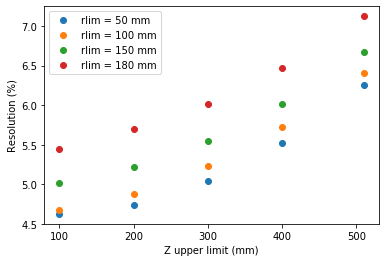

Innermost resolution =  4.62 %
Outermost resolution =  7.12 %
All resolutions: {100050: 4.6243422921162844, 100100: 4.678410964657662, 100150: 5.009310942739704, 100180: 5.450424265892685, 200050: 4.741642034164282, 200100: 4.881819231238689, 200150: 5.221205398768267, 200180: 5.692057332459469, 300050: 5.041021819401636, 300100: 5.230000820942647, 300150: 5.549962835789092, 300180: 6.018042910497088, 400050: 5.5218439162416955, 400100: 5.718569594218627, 400150: 6.019304002277609, 400180: 6.467584905837286, 510050: 6.253468719472271, 510100: 6.405054463674975, 510150: 6.67577325918231, 510180: 7.123994988133534}

================ CHECKING R2 CUT = 0.96 ================
Peak range = 5611.2 , 11638.9
Selected percentage = 10.7 \%


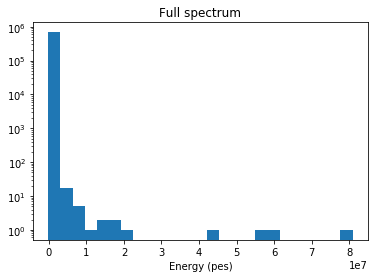

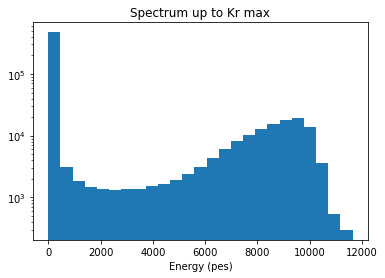

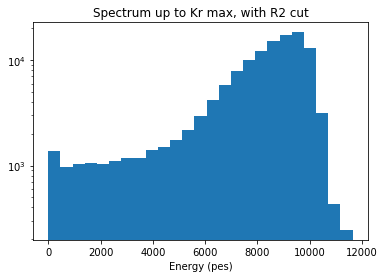

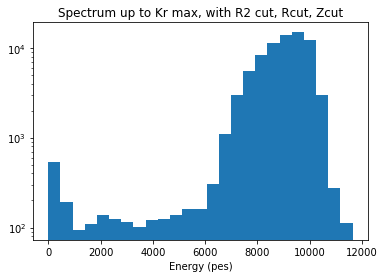

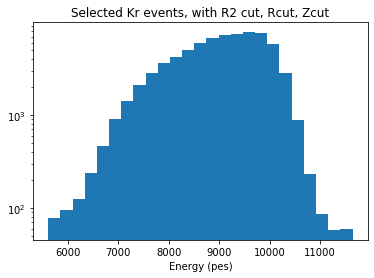

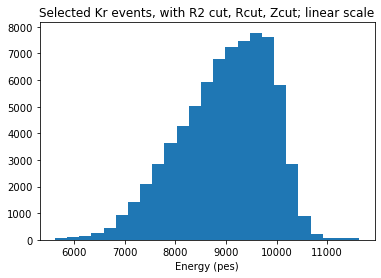

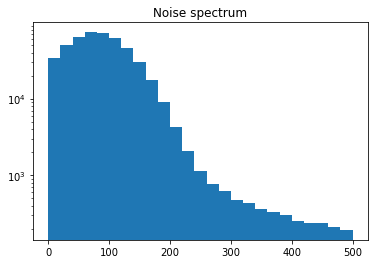

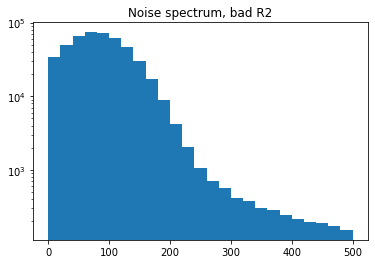

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


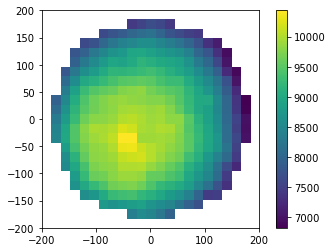

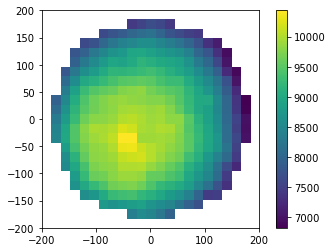

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 12.3
200000 / 583410
Est remaining = 9.7
300000 / 583410
Est remaining = 7.2
400000 / 583410
Est remaining = 4.7
500000 / 583410
Est remaining = 2.2


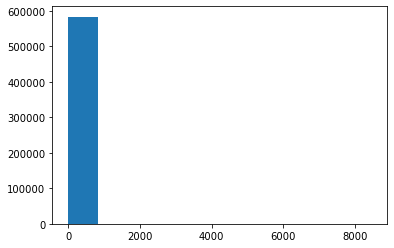

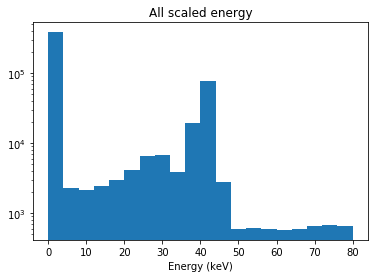

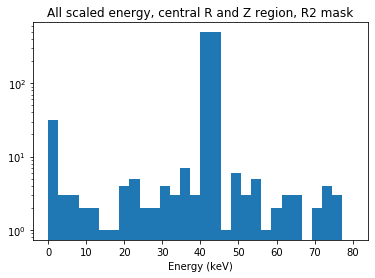

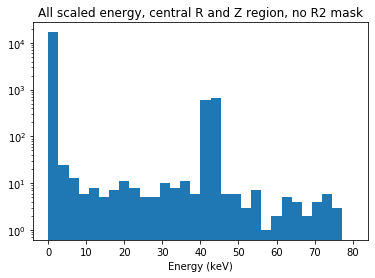

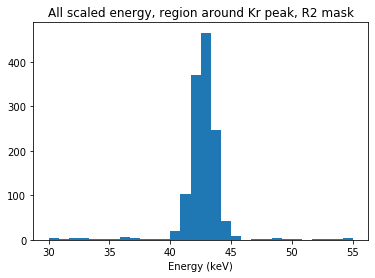

Correcting energies...
0 / 74016


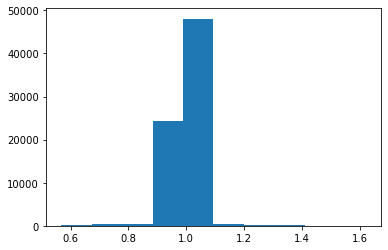

Fit a Gaussian with guess (A0, m0, s0) = (188.0, 1, 0.03851250817591462)


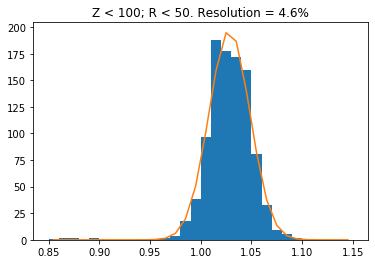

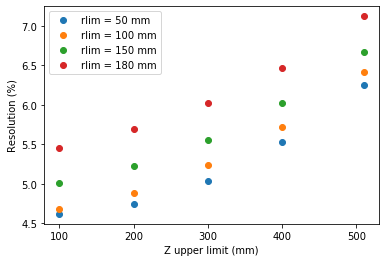

Innermost resolution =  4.62 %
Outermost resolution =  7.12 %
All resolutions: {100050: 4.618429811990106, 100100: 4.678628786216917, 100150: 5.011304963628858, 100180: 5.453611149035122, 200050: 4.740810324319253, 200100: 4.882412119831294, 200150: 5.222475189763259, 200180: 5.695131137122148, 300050: 5.041275417602582, 300100: 5.23239243385575, 300150: 5.549277640367845, 300180: 6.020238029560367, 400050: 5.524415776442327, 400100: 5.724896847321266, 400150: 6.019175341004241, 400180: 6.468262509917814, 510050: 6.258266498077855, 510100: 6.412681623292501, 510150: 6.676809348756199, 510180: 7.124384269683118}

================ CHECKING R2 CUT = 0.98 ================
Peak range = 5636.1 , 11632.9
Selected percentage = 10.7 \%


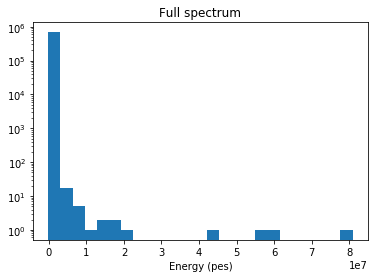

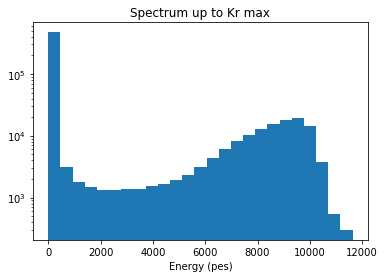

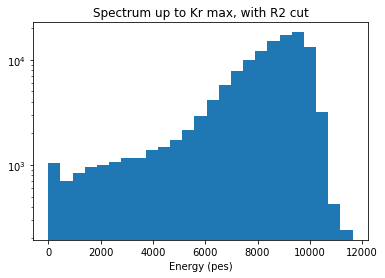

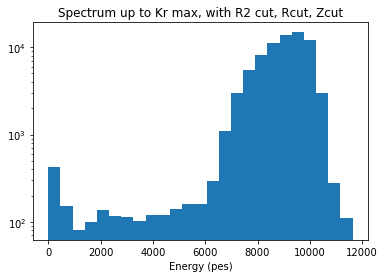

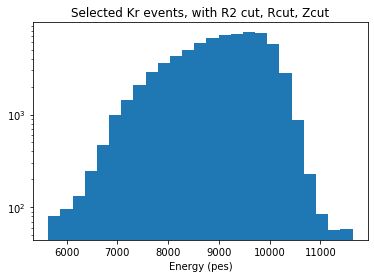

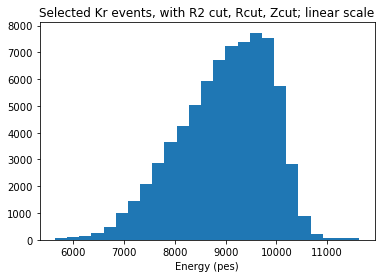

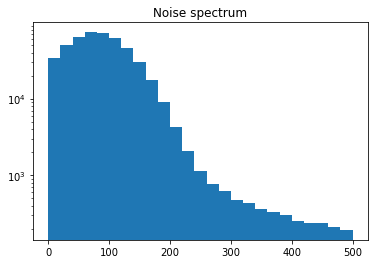

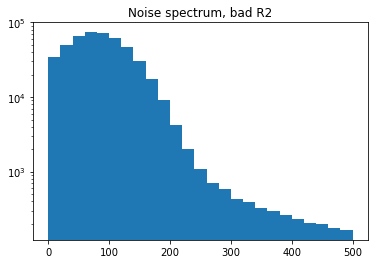

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


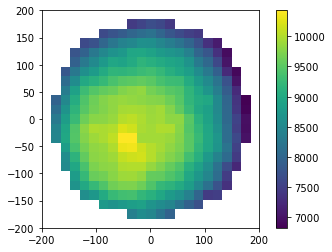

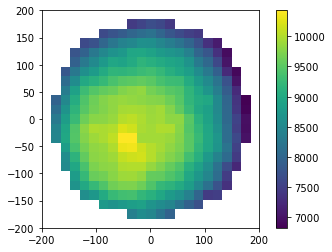

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 15.7
200000 / 583410
Est remaining = 11.5
300000 / 583410
Est remaining = 8.0
400000 / 583410
Est remaining = 5.0
500000 / 583410
Est remaining = 2.3


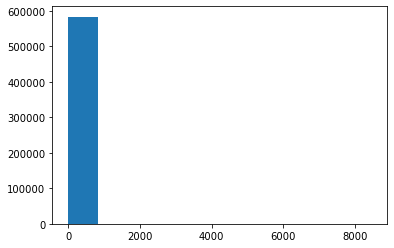

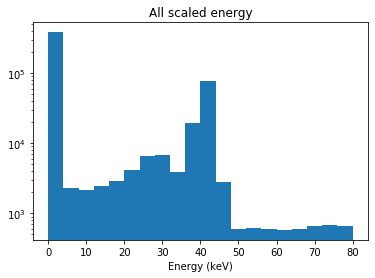

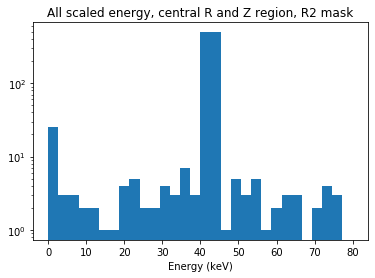

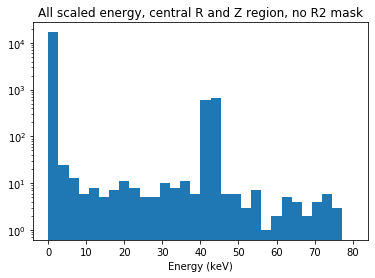

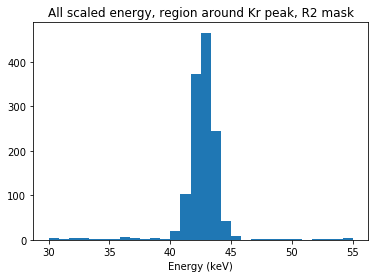

Correcting energies...
0 / 73772


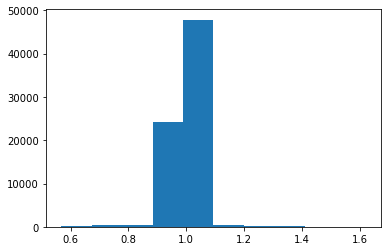

Fit a Gaussian with guess (A0, m0, s0) = (185.0, 1, 0.038232028748113725)


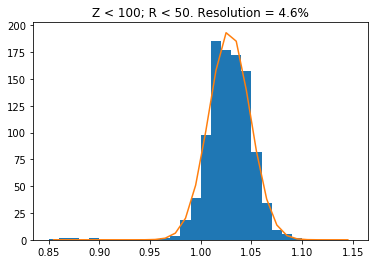

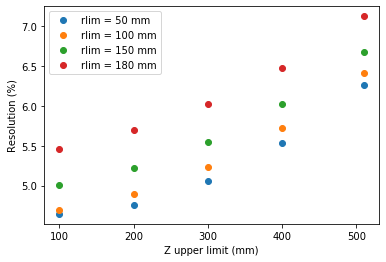

Innermost resolution =  4.65 %
Outermost resolution =  7.12 %
All resolutions: {100050: 4.6455622873250775, 100100: 4.693086305199287, 100150: 5.011108753024363, 100180: 5.457804721289337, 200050: 4.762614064616767, 200100: 4.89048385257931, 200150: 5.225621107992281, 200180: 5.699645476729161, 300050: 5.057901708324712, 300100: 5.236441839652023, 300150: 5.548607137700783, 300180: 6.020467782485413, 400050: 5.533200885446997, 400100: 5.724642421296534, 400150: 6.017719573780436, 400180: 6.467348483168361, 510050: 6.254313675881335, 510100: 6.409222298570407, 510150: 6.674009831315556, 510180: 7.121816526860477}

================ CHECKING R2 CUT = 0.99 ================
Peak range = 5673.9 , 11625.8
Selected percentage = 10.6 \%


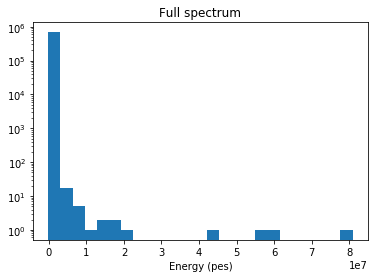

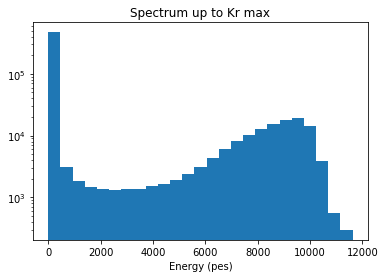

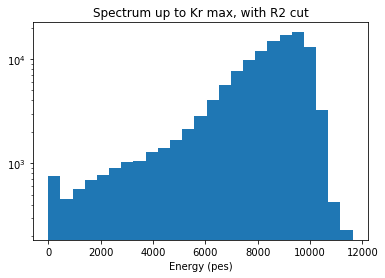

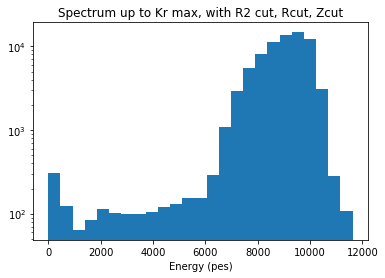

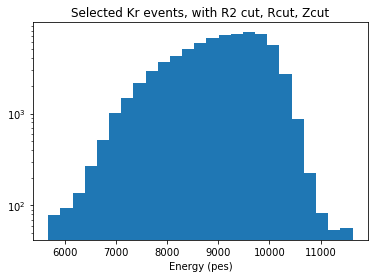

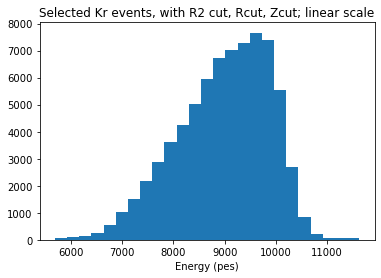

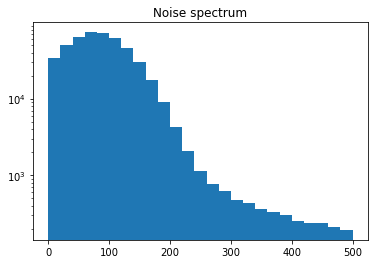

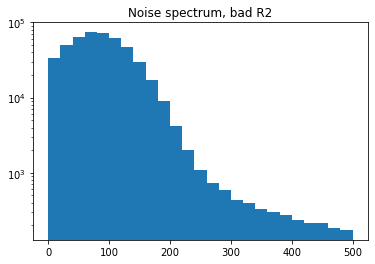

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


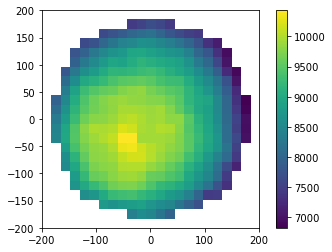

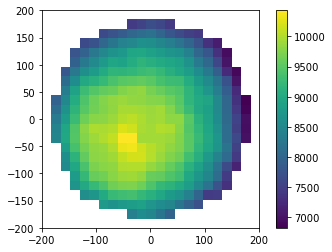

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 12.6
200000 / 583410
Est remaining = 9.5
300000 / 583410
Est remaining = 7.2
400000 / 583410
Est remaining = 4.6
500000 / 583410
Est remaining = 2.1


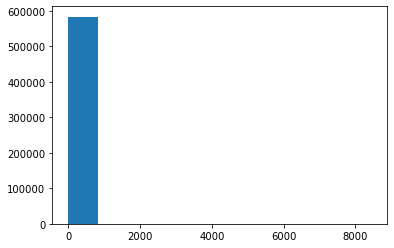

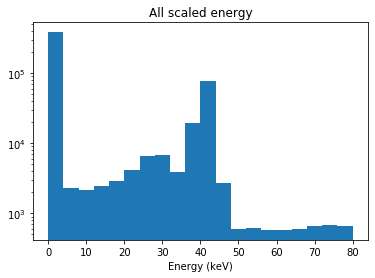

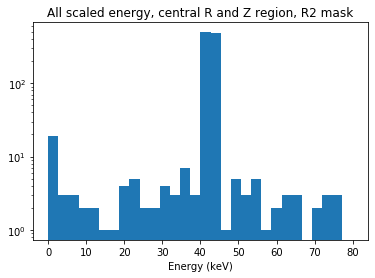

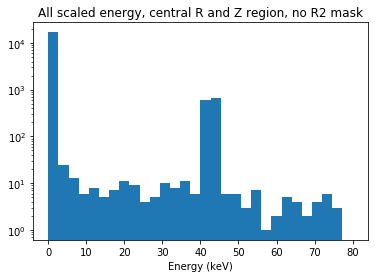

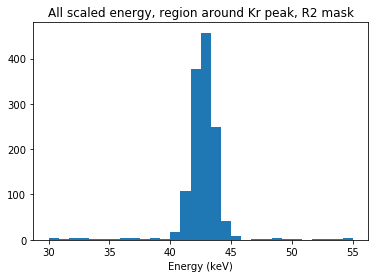

Correcting energies...
0 / 73183


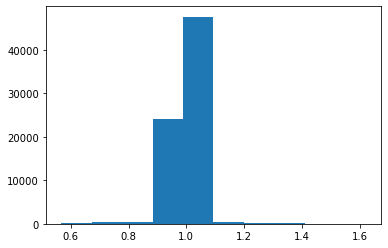

Fit a Gaussian with guess (A0, m0, s0) = (187.0, 1, 0.03803159500185973)


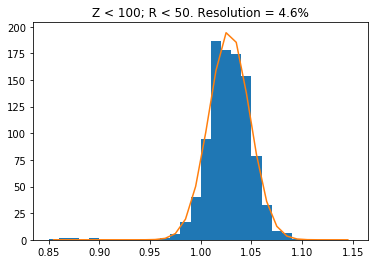

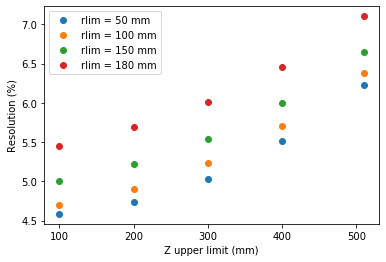

Innermost resolution =  4.59 %
Outermost resolution =  7.1 %
All resolutions: {100050: 4.58558311248967, 100100: 4.695570330606355, 100150: 5.008173673112885, 100180: 5.456226361575042, 200050: 4.735802325337626, 200100: 4.9017936325184, 200150: 5.221457117552598, 200180: 5.692917272994684, 300050: 5.029103349958971, 300100: 5.239683252537644, 300150: 5.539483938559446, 300180: 6.007426536456928, 400050: 5.515630680471206, 400100: 5.709386175480464, 400150: 6.003347644560923, 400180: 6.453170596820169, 510050: 6.222679549588378, 510100: 6.378625917770229, 510150: 6.650565171573716, 510180: 7.102135051919037}

================ CHECKING R2 CUT = 0.995 ================
Peak range = 5689.3 , 11644.3
Selected percentage = 9.9 \%


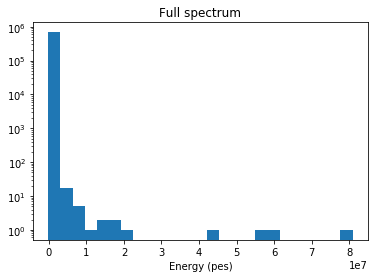

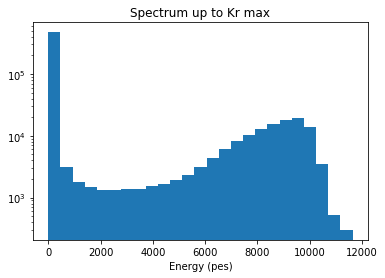

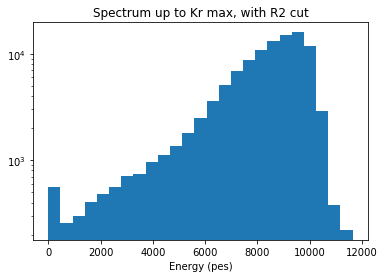

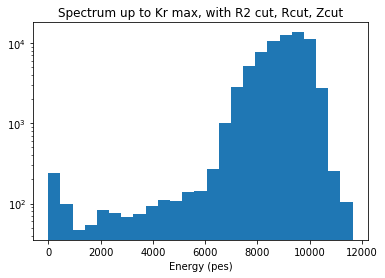

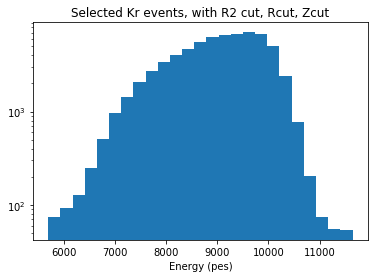

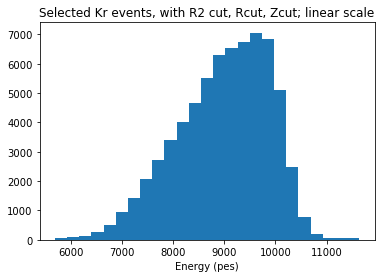

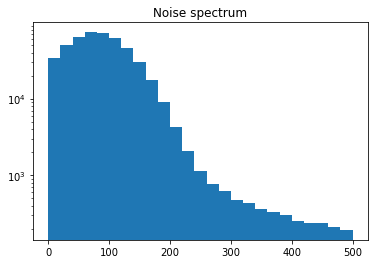

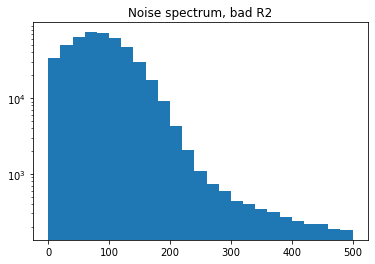

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


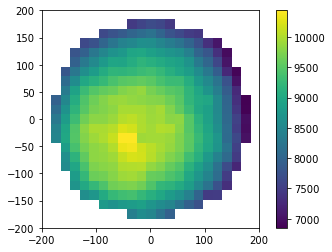

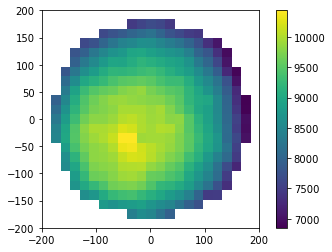

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 11.5
200000 / 583410
Est remaining = 9.1
300000 / 583410
Est remaining = 6.8
400000 / 583410
Est remaining = 4.4
500000 / 583410
Est remaining = 2.0


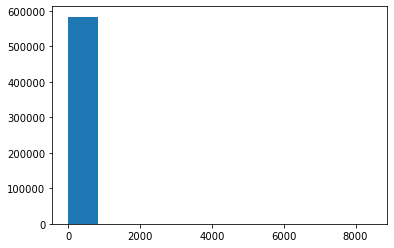

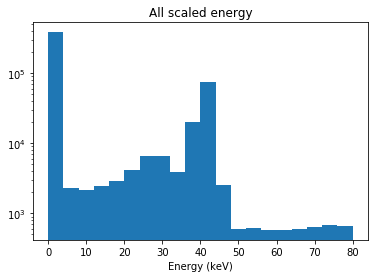

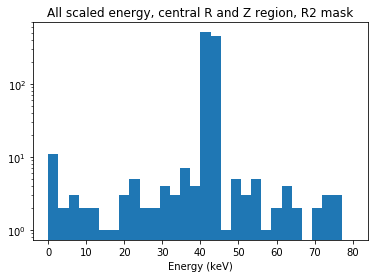

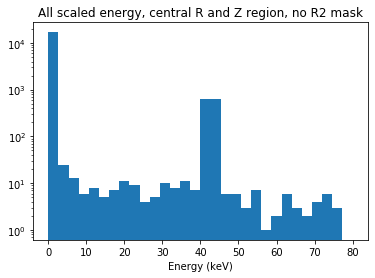

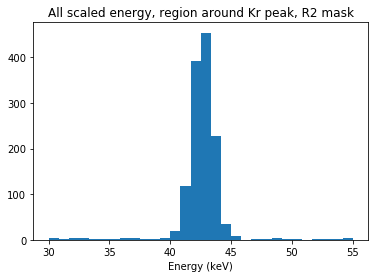

Correcting energies...
0 / 68121


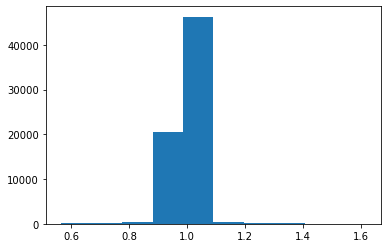

Fit a Gaussian with guess (A0, m0, s0) = (183.0, 1, 0.03836810686720326)


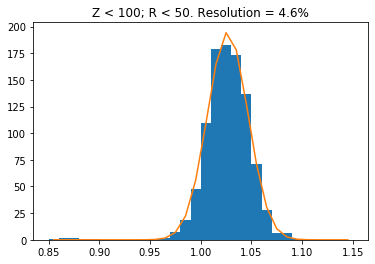

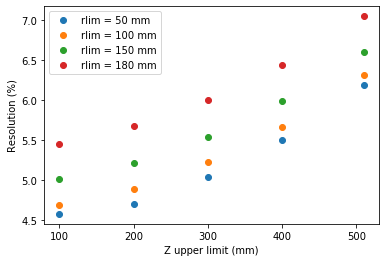

Innermost resolution =  4.58 %
Outermost resolution =  7.05 %
All resolutions: {100050: 4.5801215596745894, 100100: 4.689543883727092, 100150: 5.022647639644227, 100180: 5.459313261209471, 200050: 4.7064441101029315, 200100: 4.888564790593266, 200150: 5.222168498161879, 200180: 5.6850952413106635, 300050: 5.035907202900161, 300100: 5.224781589285877, 300150: 5.539050130574449, 300180: 5.999979929032029, 400050: 5.498633589618499, 400100: 5.67257146193152, 400150: 5.989592846936129, 400180: 6.438439387614346, 510050: 6.191559879250251, 510100: 6.316409141673625, 510150: 6.602649073345676, 510180: 7.052404632371359}


In [19]:
# r2 scan
r2s = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.995])
res_vs_zr_vs_r2 = []
goodfit = []
for r2 in r2s:
    print('\n================ CHECKING R2 CUT =', r2, '================')
    try:
        self_res_vs_zr = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, r2)
        res_vs_zr_vs_r2.append(self_res_vs_zr)
        goodfit.append(True)
    except:
        goodfit.append(False)
goodfit = np.array(goodfit)

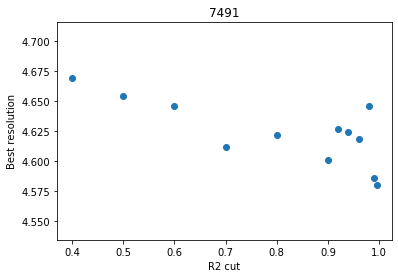

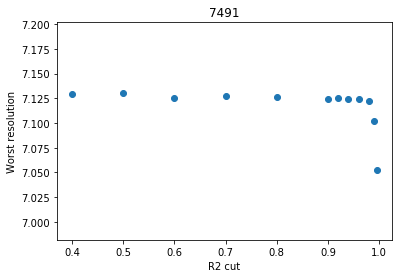

In [20]:
r2inner = [ list(x.values())[0] for x in res_vs_zr_vs_r2 ]
r2outer = [ list(x.values())[-1] for x in res_vs_zr_vs_r2 ]

plt.plot(r2s[goodfit], r2inner, 'o')
plt.ylim(min(r2inner)*0.99, max(r2inner)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Best resolution')
plt.show()

plt.plot(r2s[goodfit], r2outer, 'o')
plt.ylim(min(r2outer)*0.99, max(r2outer)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Worst resolution')
plt.show()

Peak range = 5569.0 , 11647.6
Selected percentage = 10.8 \%


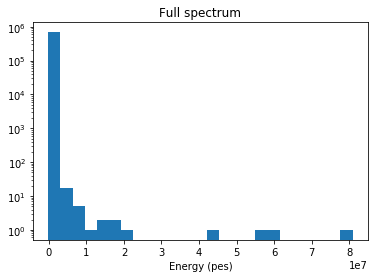

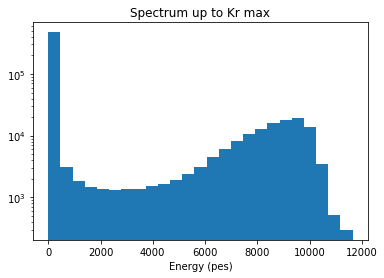

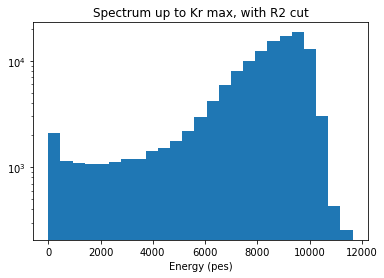

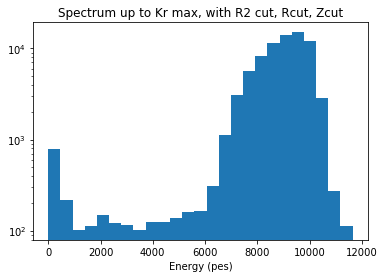

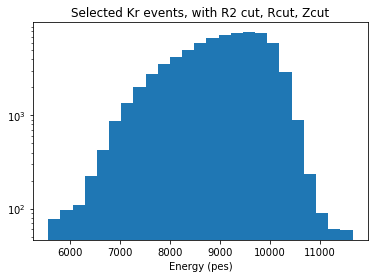

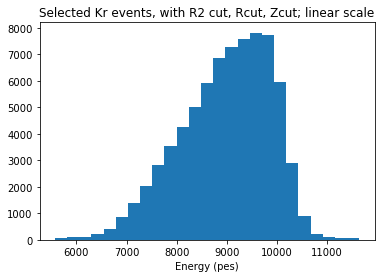

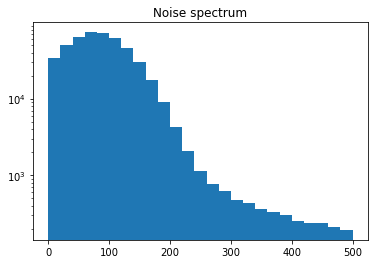

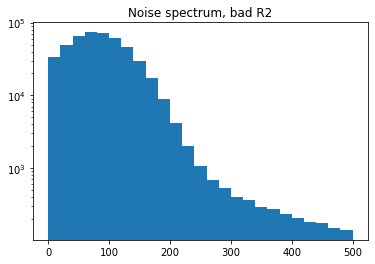

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


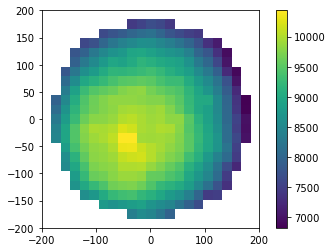

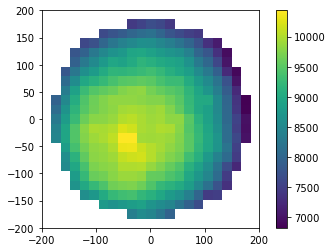

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 9.6
200000 / 583410
Est remaining = 7.8
300000 / 583410
Est remaining = 5.6
400000 / 583410
Est remaining = 3.6
500000 / 583410
Est remaining = 1.6


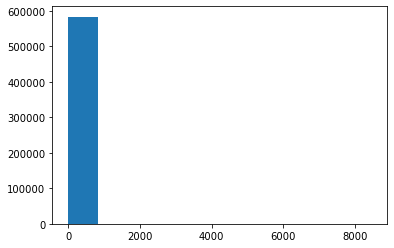

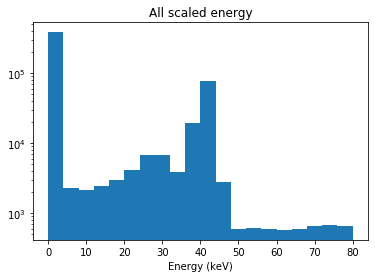

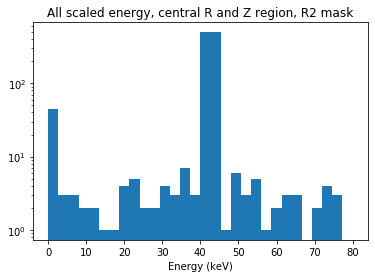

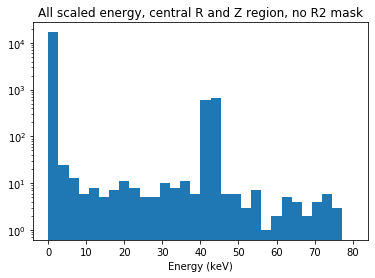

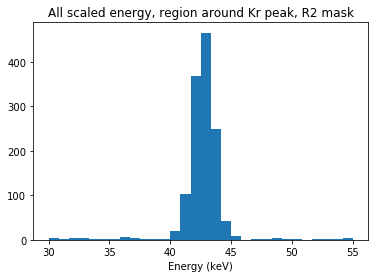

Correcting energies...
0 / 74233


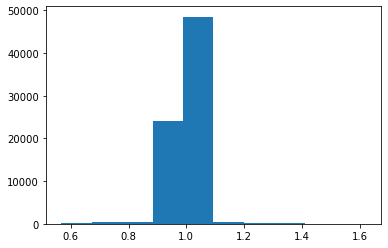

Fit a Gaussian with guess (A0, m0, s0) = (188.0, 1, 0.03847215378701846)


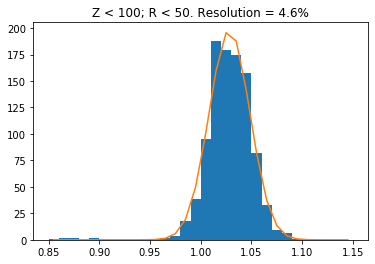

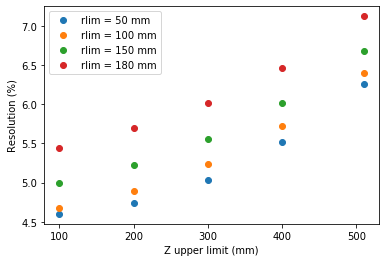

Innermost resolution =  4.6 %
Outermost resolution =  7.12 %
All resolutions: {100050: 4.600789427817213, 100100: 4.675034417518473, 100150: 4.997323995012023, 100180: 5.443770850065623, 200050: 4.739444701136124, 200100: 4.892409475804822, 200150: 5.223293312273904, 200180: 5.695221084528531, 300050: 5.039982931142444, 300100: 5.2389268746926065, 300150: 5.551244010243095, 300180: 6.021263400958608, 400050: 5.518724825976606, 400100: 5.721649378452443, 400150: 6.020476248388029, 400180: 6.46930263362804, 510050: 6.253843012432418, 510100: 6.405257158671606, 510150: 6.676223142545279, 510180: 7.12423141696898}
Peak range = 5563.2 , 11690.8
Selected percentage = 10.8 \%


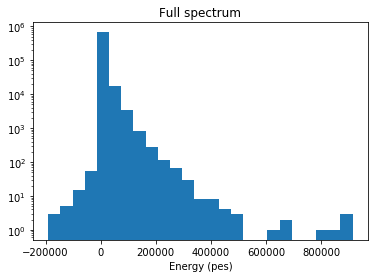

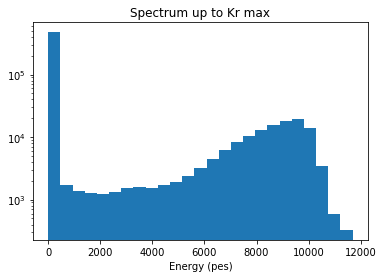

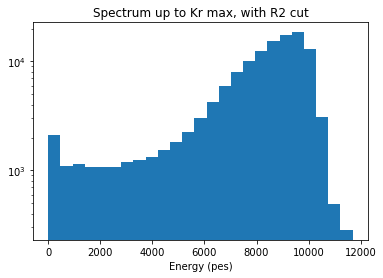

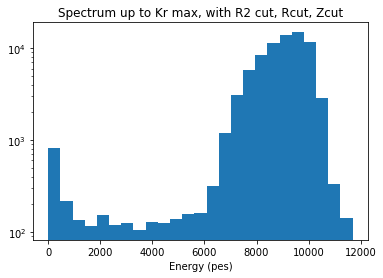

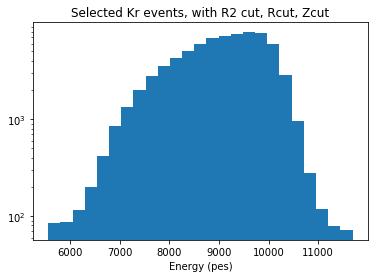

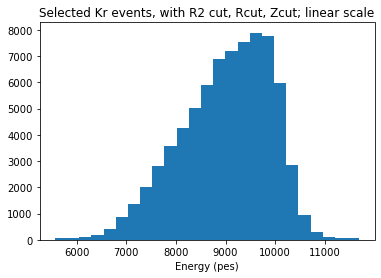

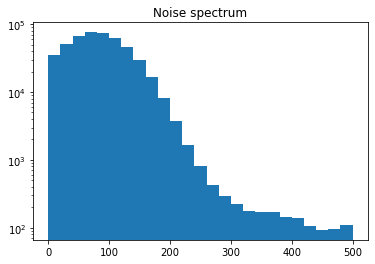

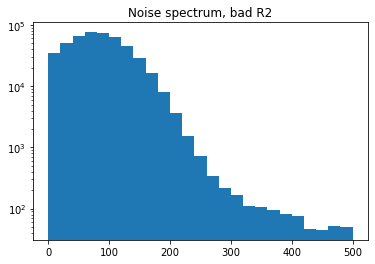

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


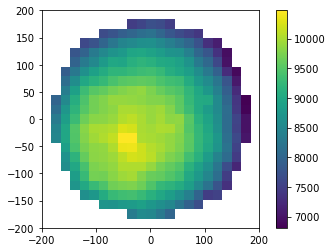

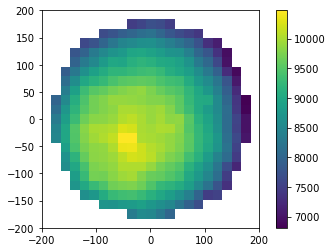

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 7.5
200000 / 583410
Est remaining = 5.6
300000 / 583410
Est remaining = 4.1
400000 / 583410
Est remaining = 2.6
500000 / 583410
Est remaining = 1.2


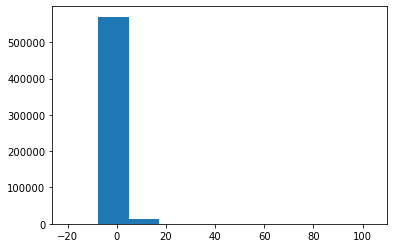

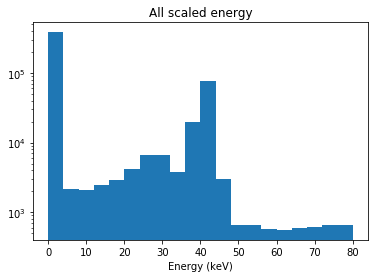

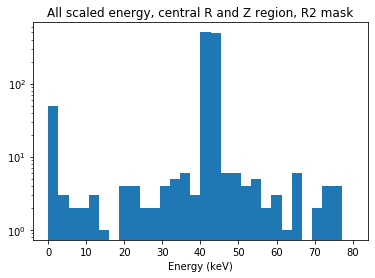

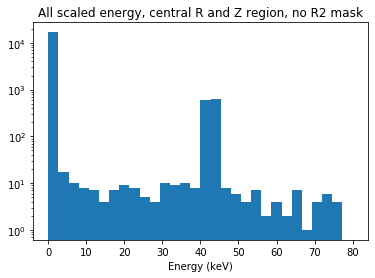

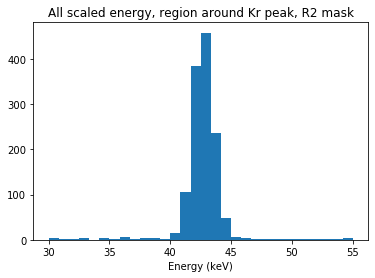

Correcting energies...
0 / 74320


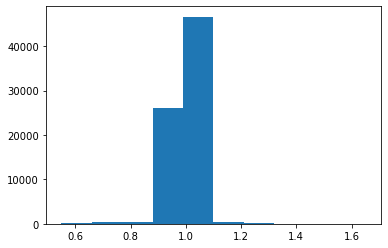

Fit a Gaussian with guess (A0, m0, s0) = (206.0, 1, 0.04049950175686841)


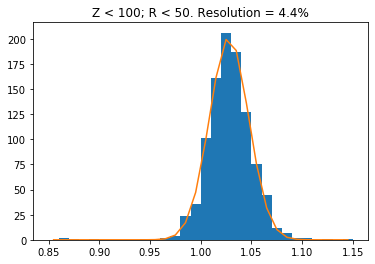

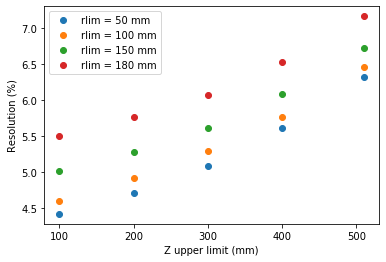

Innermost resolution =  4.42 %
Outermost resolution =  7.16 %
All resolutions: {100050: 4.421373217957671, 100100: 4.598905083113683, 100150: 5.019360640930895, 100180: 5.500975276919445, 200050: 4.7170645601942045, 200100: 4.918275321436028, 200150: 5.28276839982475, 200180: 5.760001539294167, 300050: 5.085938271278668, 300100: 5.28946863455721, 300150: 5.61056683993827, 300180: 6.071173741127055, 400050: 5.615600177466408, 400100: 5.768643326899908, 400150: 6.080932209505653, 400180: 6.526270567261652, 510050: 6.322526864983834, 510100: 6.451848301532833, 510150: 6.71631125847827, 510180: 7.158793116881548}
Peak range = 5563.2 , 11690.8
Selected percentage = 10.8 \%


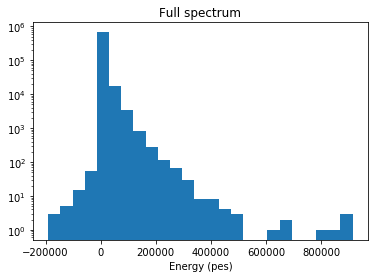

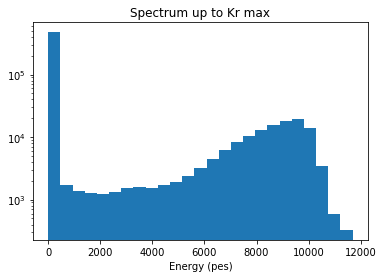

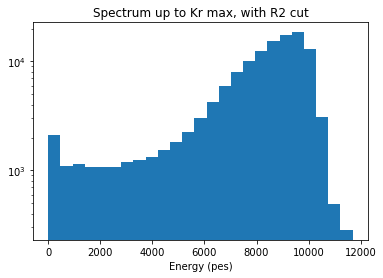

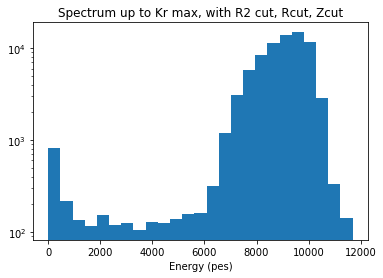

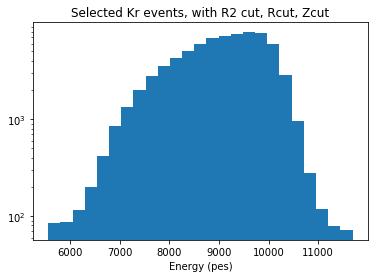

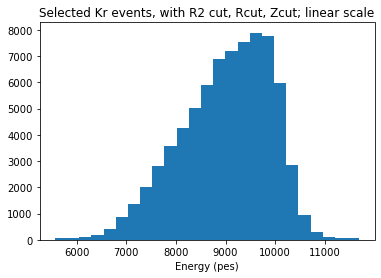

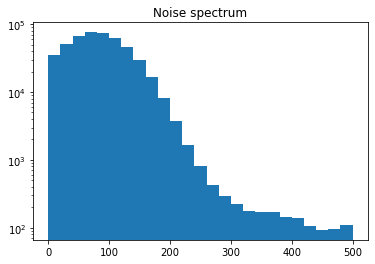

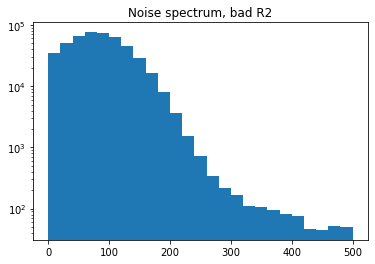

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


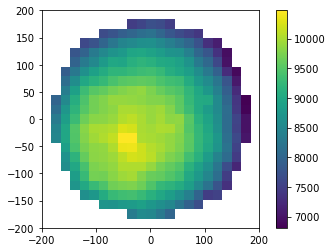

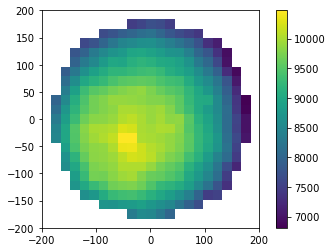

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 9.6
200000 / 583410
Est remaining = 6.9
300000 / 583410
Est remaining = 4.8
400000 / 583410
Est remaining = 3.0
500000 / 583410
Est remaining = 1.4


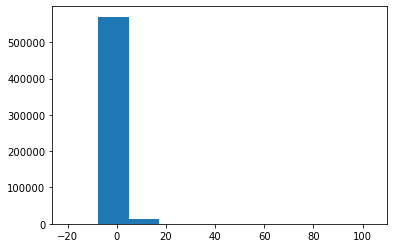

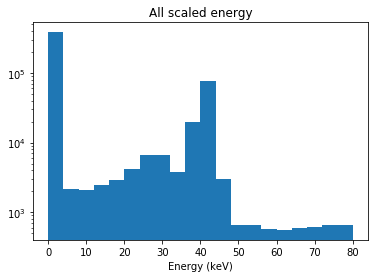

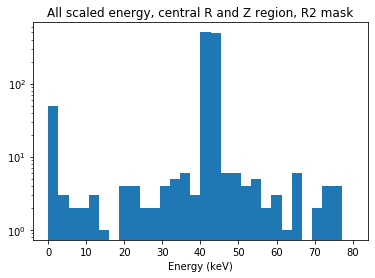

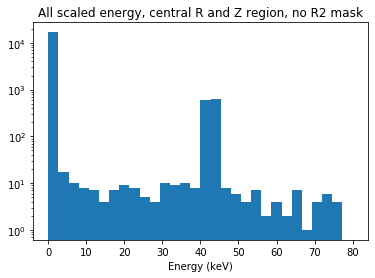

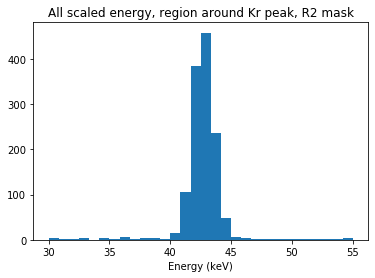

Correcting energies...
0 / 74320


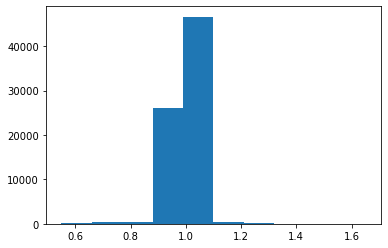

Fit a Gaussian with guess (A0, m0, s0) = (206.0, 1, 0.04049950175686841)


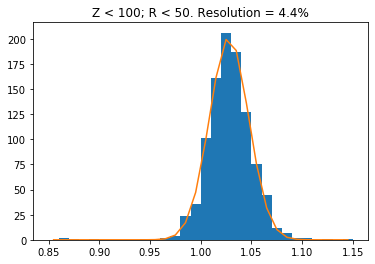

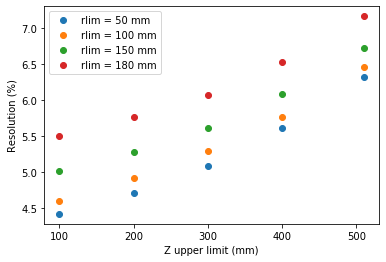

Innermost resolution =  4.42 %
Outermost resolution =  7.16 %
All resolutions: {100050: 4.421373217957671, 100100: 4.598905083113683, 100150: 5.019360640930895, 100180: 5.500975276919445, 200050: 4.7170645601942045, 200100: 4.918275321436028, 200150: 5.28276839982475, 200180: 5.760001539294167, 300050: 5.085938271278668, 300100: 5.28946863455721, 300150: 5.61056683993827, 300180: 6.071173741127055, 400050: 5.615600177466408, 400100: 5.768643326899908, 400150: 6.080932209505653, 400180: 6.526270567261652, 510050: 6.322526864983834, 510100: 6.451848301532833, 510150: 6.71631125847827, 510180: 7.158793116881548}


In [21]:
try:
    pre_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    post_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_post, 0.9)
    avg_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_avg, 0.9)
except:
    pass

In [22]:
try:
    print('Inner res for pre, post, avg:')
    print(round(list(pre_res.values())[0], 2), ',', round(list(post_res.values())[0], 2), ',', round(list(avg_res.values())[0], 2))
    print('Outer res for pre, post, avg:')
    print(round(list(pre_res.values())[-1], 2), ',', round(list(post_res.values())[-1], 2), ',', round(list(avg_res.values())[-1], 2))
except:
    pass

Inner res for pre, post, avg:
4.6 , 4.42 , 4.42
Outer res for pre, post, avg:
7.12 , 7.16 , 7.16


Peak range = 5569.0 , 11647.6
Selected percentage = 10.8 \%


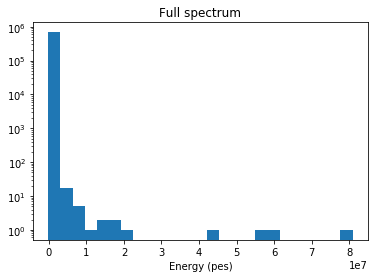

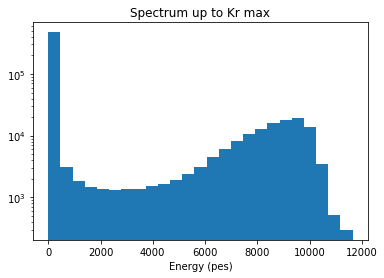

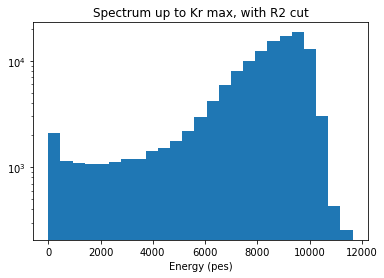

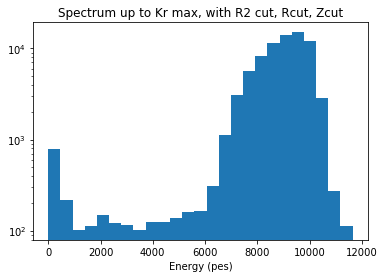

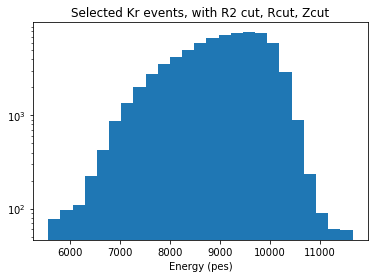

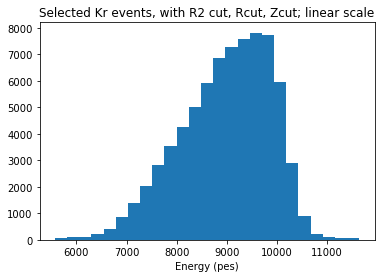

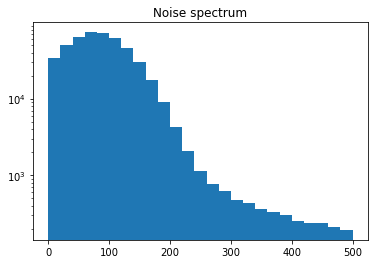

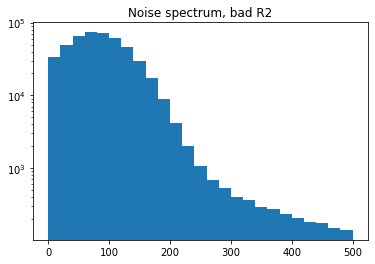

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


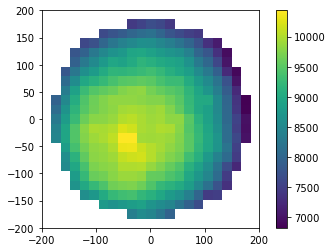

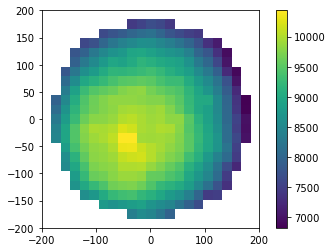

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 7.7
200000 / 583410
Est remaining = 6.1
300000 / 583410
Est remaining = 4.4
400000 / 583410
Est remaining = 2.8
500000 / 583410
Est remaining = 1.3


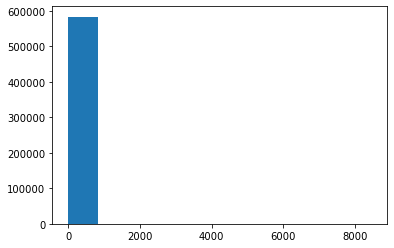

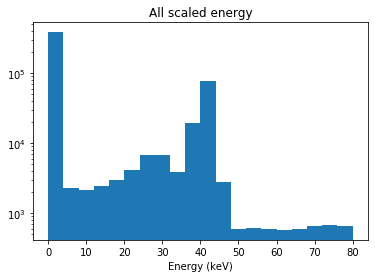

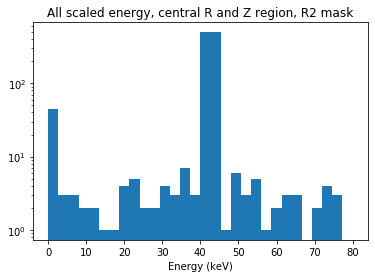

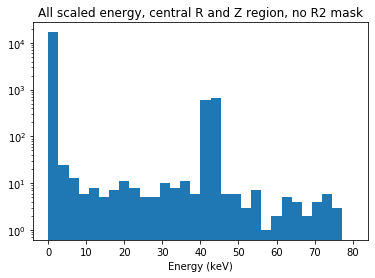

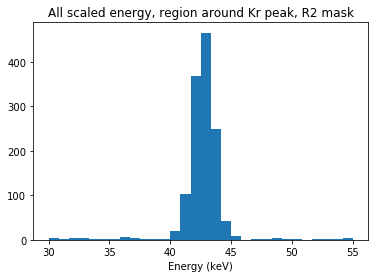

Correcting energies...
0 / 74233


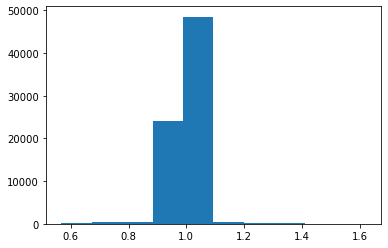

Fit a Gaussian with guess (A0, m0, s0) = (188.0, 1, 0.03847215378701846)


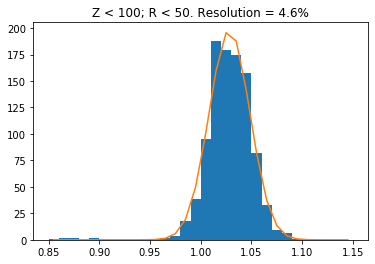

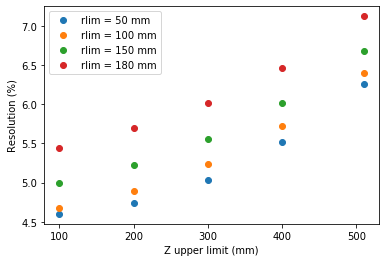

Innermost resolution =  4.6 %
Outermost resolution =  7.12 %
All resolutions: {100050: 4.600789427817213, 100100: 4.675034417518473, 100150: 4.997323995012023, 100180: 5.443770850065623, 200050: 4.739444701136124, 200100: 4.892409475804822, 200150: 5.223293312273904, 200180: 5.695221084528531, 300050: 5.039982931142444, 300100: 5.2389268746926065, 300150: 5.551244010243095, 300180: 6.021263400958608, 400050: 5.518724825976606, 400100: 5.721649378452443, 400150: 6.020476248388029, 400180: 6.46930263362804, 510050: 6.253843012432418, 510100: 6.405257158671606, 510150: 6.676223142545279, 510180: 7.12423141696898}
Peak range = 5600.9 , 11650.4
Selected percentage = 10.4 \%


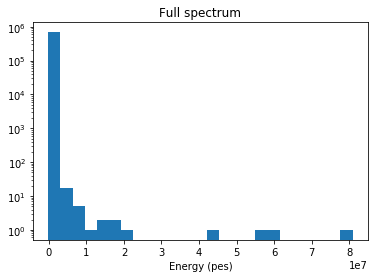

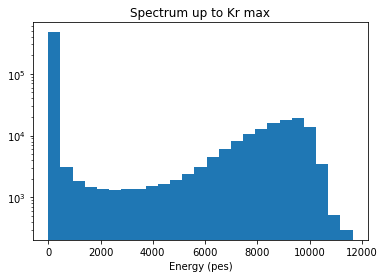

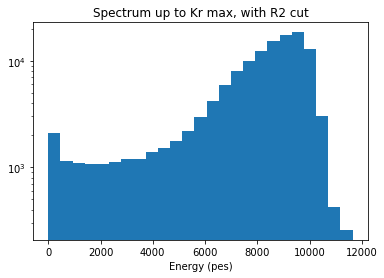

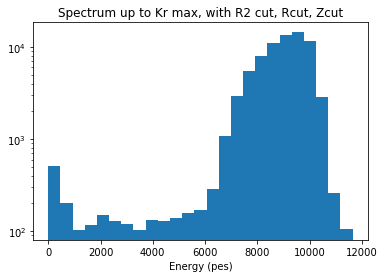

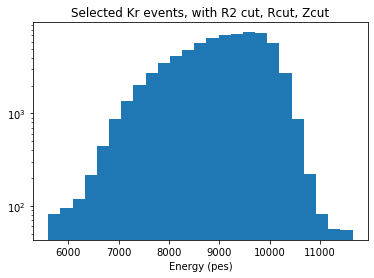

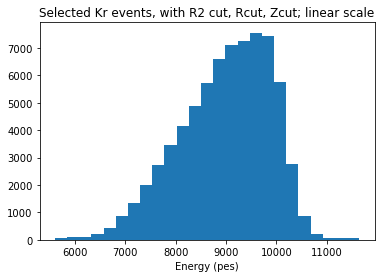

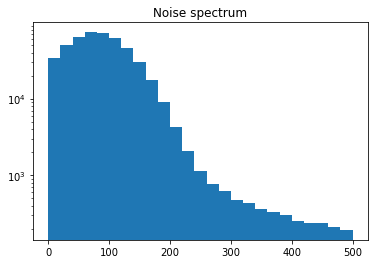

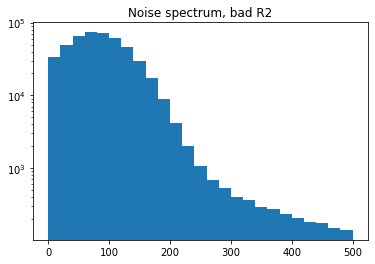

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


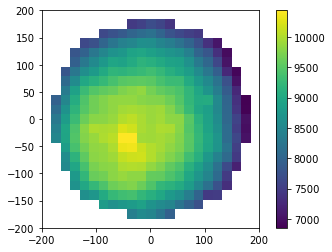

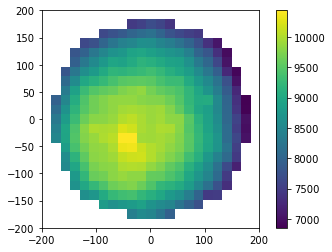

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 7.4
200000 / 583410
Est remaining = 5.8
300000 / 583410
Est remaining = 4.5
400000 / 583410
Est remaining = 3.0
500000 / 583410
Est remaining = 1.6


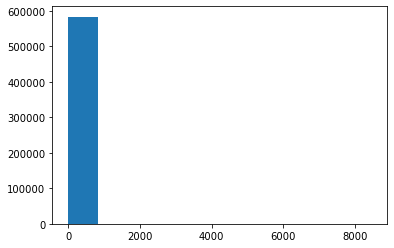

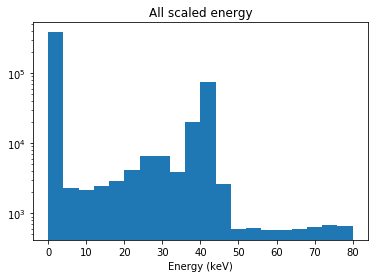

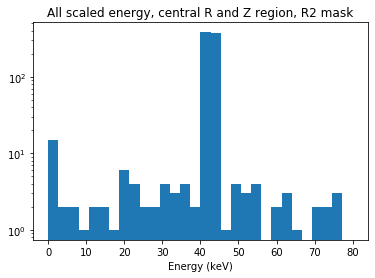

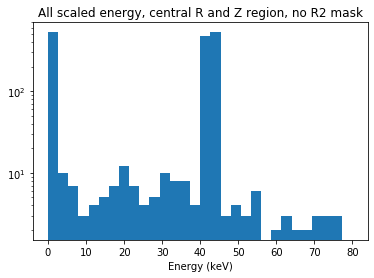

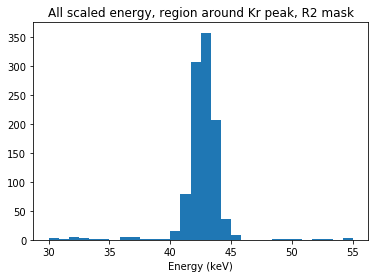

Correcting energies...
0 / 71946


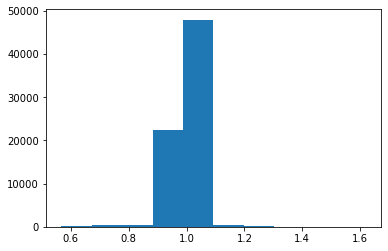

Fit a Gaussian with guess (A0, m0, s0) = (146.0, 1, 0.0444049988803798)


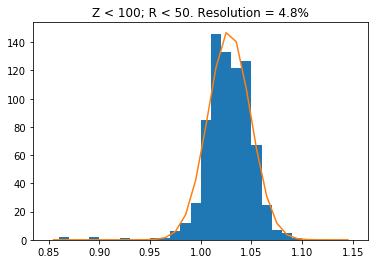

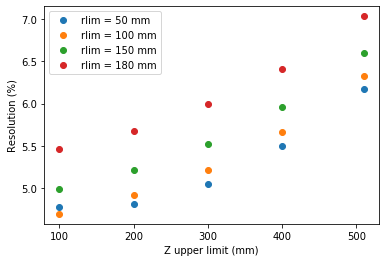

Innermost resolution =  4.78 %
Outermost resolution =  7.03 %
All resolutions: {100050: 4.777949050437906, 100100: 4.698506473711143, 100150: 4.996287441571955, 100180: 5.463943032328129, 200050: 4.817640032324268, 200100: 4.926487870750498, 200150: 5.218342822828787, 200180: 5.673642131142351, 300050: 5.05546689002192, 300100: 5.2160221837336085, 300150: 5.527485843509938, 300180: 5.996427269923813, 400050: 5.49743853958791, 400100: 5.6640498577136, 400150: 5.965509644456704, 400180: 6.414407775945804, 510050: 6.1697354311538914, 510100: 6.323985240221676, 510150: 6.59486604686791, 510180: 7.031379049574703}


In [23]:
try:
    res_gauss = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    res_rms = check_resolution(histat_Zrms, histat_events_energy_subtracted_pre, 0.9)
except:
    pass

In [24]:
try:
    print('Inner res for rms, gauss:')
    print(round(list(res_rms.values())[0], 2), ',', round(list(res_gauss.values())[0], 2))
    print('Outer res for rms, gauss:')
    print(round(list(res_rms.values())[-1], 2), ',', round(list(res_gauss.values())[-1], 2))
except:
    pass

Inner res for rms, gauss:
4.78 , 4.6
Outer res for rms, gauss:
7.03 , 7.12


Peak range = 5569.0 , 11647.6
Selected percentage = 10.8 \%


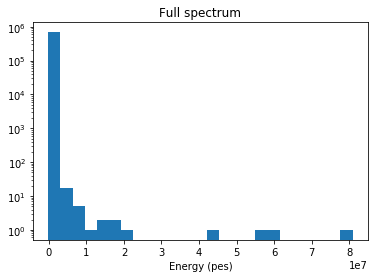

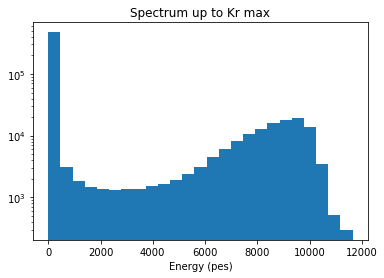

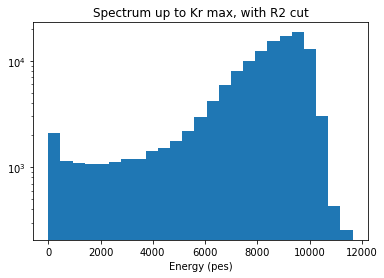

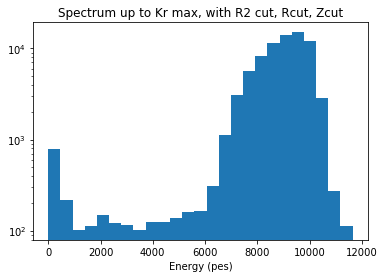

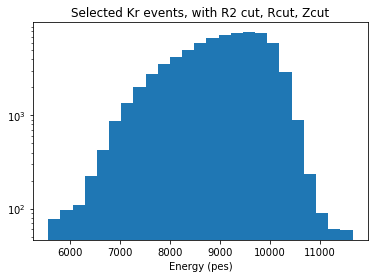

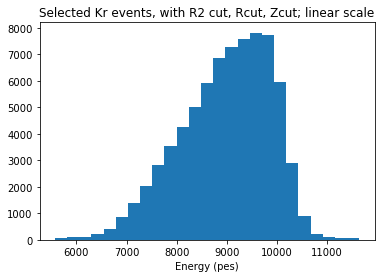

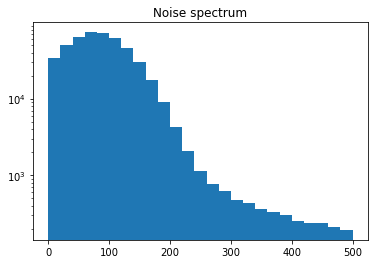

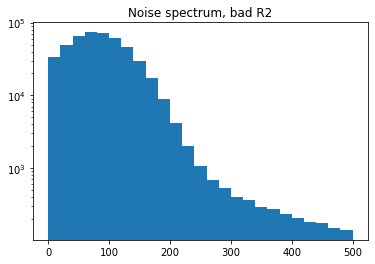

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


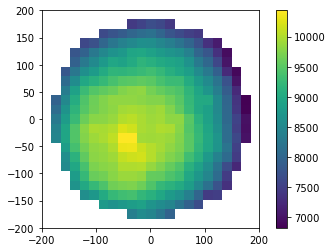

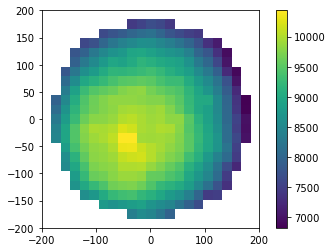

Correcting energies...
0 / 583410
100000 / 583410
Est remaining = 7.7
200000 / 583410
Est remaining = 5.8
300000 / 583410
Est remaining = 4.2
400000 / 583410
Est remaining = 2.7
500000 / 583410
Est remaining = 1.1


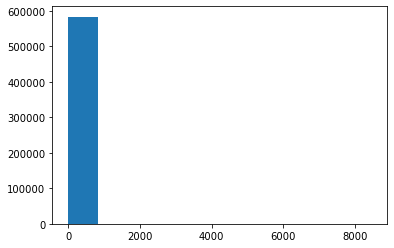

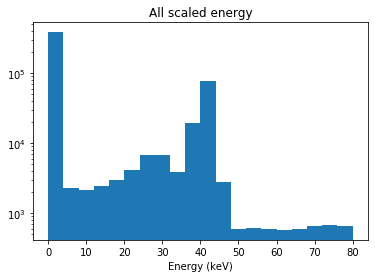

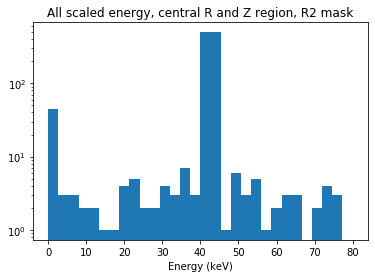

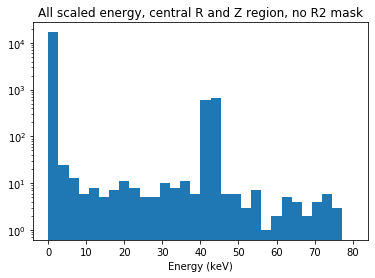

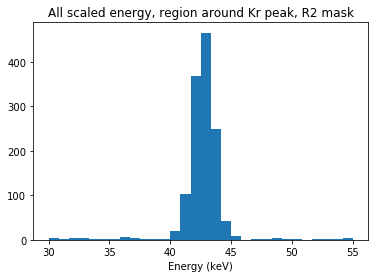

Correcting energies...
0 / 74233


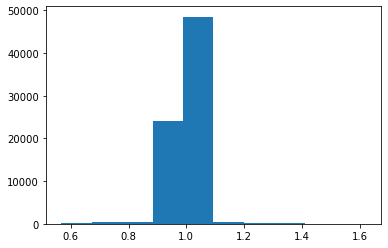

Fit a Gaussian with guess (A0, m0, s0) = (188.0, 1, 0.03847215378701846)


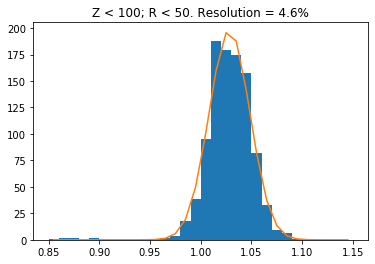

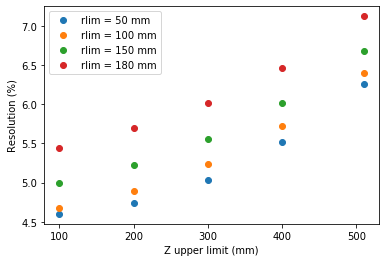

Innermost resolution =  4.6 %
Outermost resolution =  7.12 %
All resolutions: {100050: 4.600789427817213, 100100: 4.675034417518473, 100150: 4.997323995012023, 100180: 5.443770850065623, 200050: 4.739444701136124, 200100: 4.892409475804822, 200150: 5.223293312273904, 200180: 5.695221084528531, 300050: 5.039982931142444, 300100: 5.2389268746926065, 300150: 5.551244010243095, 300180: 6.021263400958608, 400050: 5.518724825976606, 400100: 5.721649378452443, 400150: 6.020476248388029, 400180: 6.46930263362804, 510050: 6.253843012432418, 510100: 6.405257158671606, 510150: 6.676223142545279, 510180: 7.12423141696898}


{100050: 4.600789427817213,
 100100: 4.675034417518473,
 100150: 4.997323995012023,
 100180: 5.443770850065623,
 200050: 4.739444701136124,
 200100: 4.892409475804822,
 200150: 5.223293312273904,
 200180: 5.695221084528531,
 300050: 5.039982931142444,
 300100: 5.2389268746926065,
 300150: 5.551244010243095,
 300180: 6.021263400958608,
 400050: 5.518724825976606,
 400100: 5.721649378452443,
 400150: 6.020476248388029,
 400180: 6.46930263362804,
 510050: 6.253843012432418,
 510100: 6.405257158671606,
 510150: 6.676223142545279,
 510180: 7.12423141696898}

In [25]:
# Output the proper map
check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)

In [26]:
print('Total time =',  round((time() - t0)/60,1), 'minutes')

Total time = 18.4 minutes
